# 1. Introduction

This document presents an intensive exploratory loan_data analysis (EDA) and statistical analysis of a loan status loan_dataset. The goal is to uncover patterns, relationships, and insights that can help predict loan statuss. The analysis includes:

- loan_data preprocessing and cleaning
- Univariate analysis with advanced visualizations
- Bivariate and multivariate analysis
- Correlation analysis with sophisticated visualizations
- Feature importance and selection
- Statistical modeling and predictive analysis
- Advanced dimensionality reduction and visualization techniques

Let's begin by loading and examining the loan_dataset.

# 2. loan_data Loading and Initial Exploration

In [10]:
# Use librarian to load and manage libraries
librarian::shelf(
  # Data manipulation and tidyverse
  tidyverse, tidymodels, janitor, skimr,
  
  # Visualization
  GGally, corrplot, plotly, viridis, 
  ggthemes, ggridges, scales, vcd, 
  RColorBrewer, ggraph, DataExplorer,
  
  # Machine Learning and Statistical Tools
  pROC, factoextra, cluster, 
  MASS, Rtsne, tsne, umap, 
  caTools, PCAtest,naniar,vip,
  xgboost, caret, finetune, dendextend,
  elasticnet, PMA, rospca, factoextra,
  
  # Additional Utilities
  conflicted, gridExtra, 
  kableExtra, DT, 
  igraph, qgraph, 
  entropy

)

# Resolve conflicts
conflicted::conflicts_prefer(dplyr::select)
tidymodels_prefer()

# Custom ggplot theme
theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

# Data loading and preprocessing function
prepare_loan_data <- function(file_path, sample_size = 50000) {
  # Read the CSV file
  loan_data <- read_csv(file_path, show_col_types = FALSE) %>%
    clean_names() %>%
    select(-id)
  
  # Set random seed for reproducibility
  set.seed(42)
  # Split the dataset
  split_ratio <- 1000 / nrow(loan_data)
  split_index <- sample.split(loan_data$status, SplitRatio = split_ratio)
  data <- loan_data[split_index, ]
  
  # Print data information
  message("Original dataset dimensions:", nrow(loan_data), "rows,", ncol(loan_data), "columns\n")
  message("Sampled dataset dimensions:", nrow(data), "rows,", ncol(data), "columns\n")
  
  # Print status distribution
  message("Status distribution in original dataset:")
  print(prop.table(table(loan_data$status)))
  
  message("Status distribution in sampled dataset:")
  print(prop.table(table(data$status)))
  
  return(data)
}

# Main script execution
main <- function() {
  # Prepare the loan data
  data <- prepare_loan_data("../dataset/Loan_Default.csv")
  data <- data %>% 
    mutate_if(is.character, as.factor) %>% 
    mutate(status = factor(status, levels= c("0", "1"), labels = c("No", "Yes")))
  
  # Generate summary statistics
  summary_stats <- data %>%
    skim() %>%
    kable(caption = "Summary statistics for the loan data")
  
  print(summary_stats)
  return(data)
}

# Run the main script
data <- main()


[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::select over any other package.
Original dataset dimensions:148670rows,33columns

Sampled dataset dimensions:500rows,33columns

Status distribution in original dataset:

        0         1 
0.7535549 0.2464451 
Status distribution in sampled dataset:

    0     1 
0.754 0.246 


Table: Summary statistics for the loan data

|skim_type |skim_variable             | n_missing| complete_rate|factor.ordered | factor.n_unique|factor.top_counts                     | numeric.mean|   numeric.sd|  numeric.p0| numeric.p25|  numeric.p50| numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------------------|---------:|-------------:|:--------------|---------------:|:-------------------------------------|------------:|------------:|-----------:|-----------:|------------:|-----------:|------------:|:------------|
|factor    |loan_limit                |        12|         0.976|FALSE          |               2|cf: 456,

## Missing loan_data Analysis


               loan_limit                    gender             approv_in_adv 
                        0                         0                         0 
                loan_type              loan_purpose    business_or_commercial 
                        0                         0                         0 
              loan_amount          rate_of_interest      interest_rate_spread 
                        0                         0                         0 
          upfront_charges                      term         neg_ammortization 
                        0                         0                         0 
           property_value                    income               credit_type 
                        0                         0                         0 
             credit_score  co_applicant_credit_type                       age 
                        0                         0                         0 
submission_of_application                       ltv 

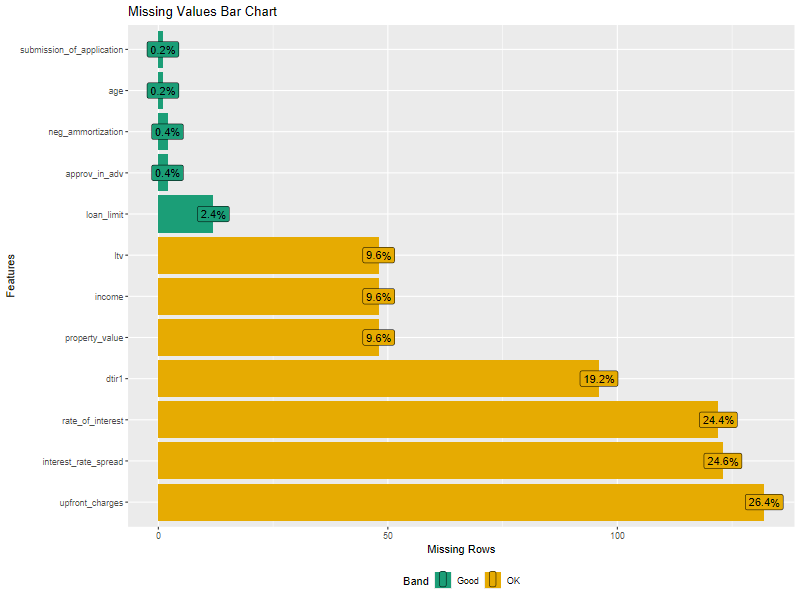

In [11]:
analyze_and_impute_missing <- function(data) {
  # Missing value visualization
  print(plot_missing(data, missing_only = TRUE, title = "Missing Values Bar Chart"))
  
  # Remove zero-variance columns and apply KNN imputation
  data <- recipe(status ~ ., data) %>% 
    step_nzv(all_predictors()) %>% 
    step_impute_knn(all_predictors()) %>% 
    prep() %>% 
    bake(new_data = NULL)

  # Sanity Checks
  print(colSums(is.na(data)))
  
  return(data)
}

# Apply the function
data <- analyze_and_impute_missing(data)

# 3. Univariate Analysis

## 3.1 Distribution of Numeric loan_amounts

In [12]:
# Identify numeric and categorical columns
numeric_cols <- names(select(data, where(is.numeric)))
categorical_cols <- names(select(data, where(negate(is.numeric))))
numeric_data <- data %>% 
  select(any_of(c(numeric_cols, "status"))) %>% 
  pivot_longer(cols = -status, names_to = "features", values_to = "values")

In [13]:
options(repr.plot.height = 24, repr.plot.width = 24)
status_counts <- function(data) {
  percentage_count <- data %>% 
    count(status) %>% 
    mutate(percentage = n / sum(n) * 100)

  p1 <- ggplot(data, aes(status, fill = status)) +
    geom_bar(width = 0.7) +
    geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
    scale_fill_viridis_d(option = "D") +
    labs(title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(data)),
      fill = "Loan Status")
  ggsave(filename= "../plots/eda_images/stats_count.png", plot = p1, dpi = 300, width = 8, height = 8)
  print(p1)
}


feature_distributions <- function(data){
  p2 <- ggplot(numeric_data, aes(values, fill = status)) +
  geom_density(alpha = 0.6) +
  geom_rug(alpha = 0.6, color = "#e74c3c") +
  facet_wrap(~features, scales = "free") +
  labs(title = "Feature Distributions by Loan Status",
  x = "Value", y = "Density") +
  scale_fill_manual(values = c("No" = "#66c2a5", 
  "Yes" = "#fc8d62")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
     legend.position = "bottom")
  ggsave(filename= "../plots/eda_images/feature_distributions.png", plot = p2, dpi = 300, width = 8, height = 8)
  print(p2)
}

# Function to plot boxplots with violin overlay
boxviolin <- function(data, variable) {
  q <- quantile(data[[variable]], probs = c(0.25, 0.75), na.rm = TRUE)
  iqr <- diff(q)
  bounds <- q + c(-1.5, 1.5) * iqr
  outlier_pct <- mean(data[[variable]] < bounds[1] | data[[variable]] > bounds[2], na.rm = TRUE) * 100
  
  p3 <- ggplot(data, aes(y = .data[[variable]], x = "")) +
    geom_violin(fill = "#9b59b6", alpha = 0.6) +
    geom_boxplot(width = 0.1, fill = "#3498db", alpha = 0.7, outlier.color = "#e74c3c") +
    labs(
      title = paste("Distribution of", variable),
      subtitle = sprintf("IQR = %.2f | Outliers = %.2f%%", iqr, outlier_pct),
      y = variable, x = ""
    ) +
    theme_minimal()

}



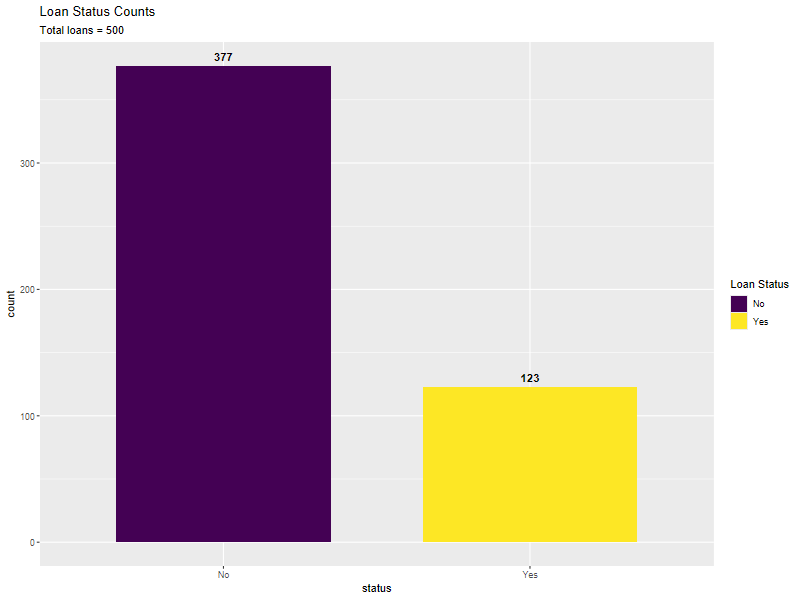

In [14]:
status_counts(data)

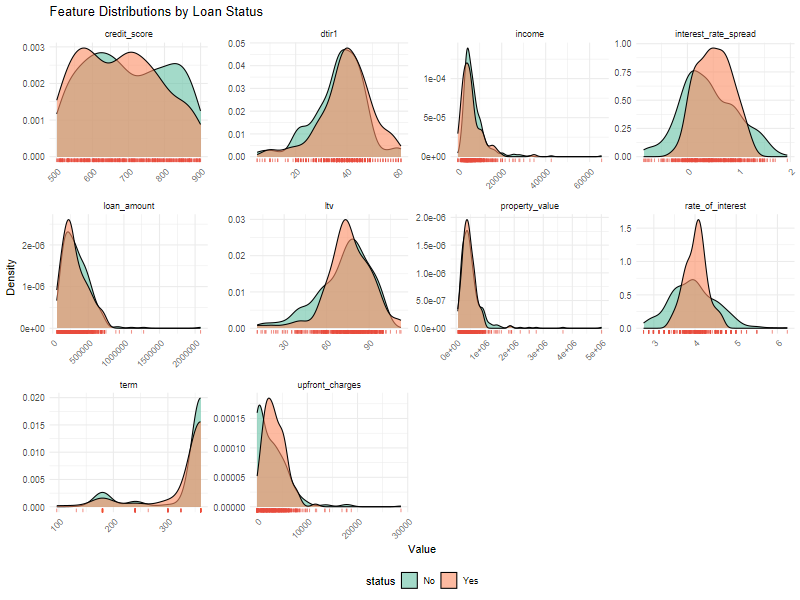

In [15]:
feature_distributions(data)

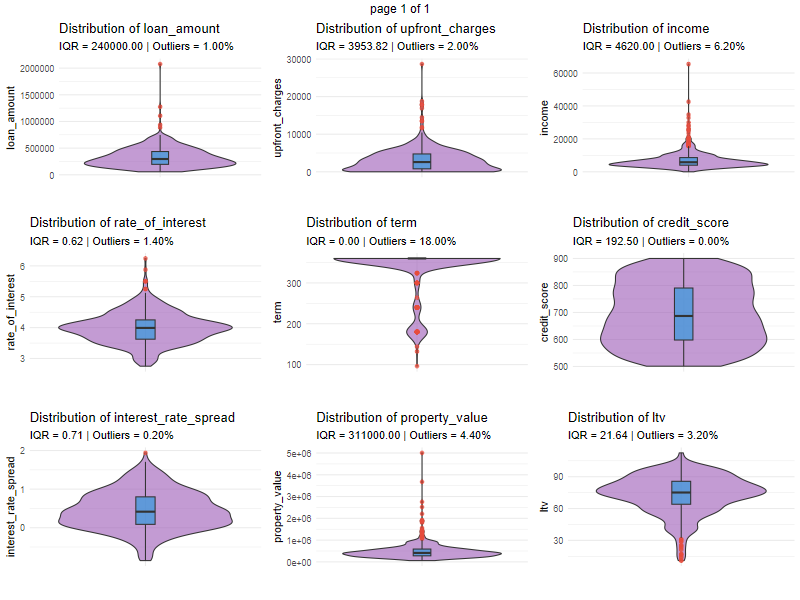

[[1]]
NULL


In [16]:
# Generate and arrange plots for first 9 numeric features
plots <- lapply(head(numeric_cols, 9), boxviolin, data = data)
arranged_plot <- marrangeGrob(plots, ncol = 3, nrow = 3) 

# Save the arranged plot
ggsave(filename = "../plots/eda_images/boxviolin.png", plot = arranged_plot, dpi = 300, width = 10, height = 10)

grid.draw(arranged_plot)

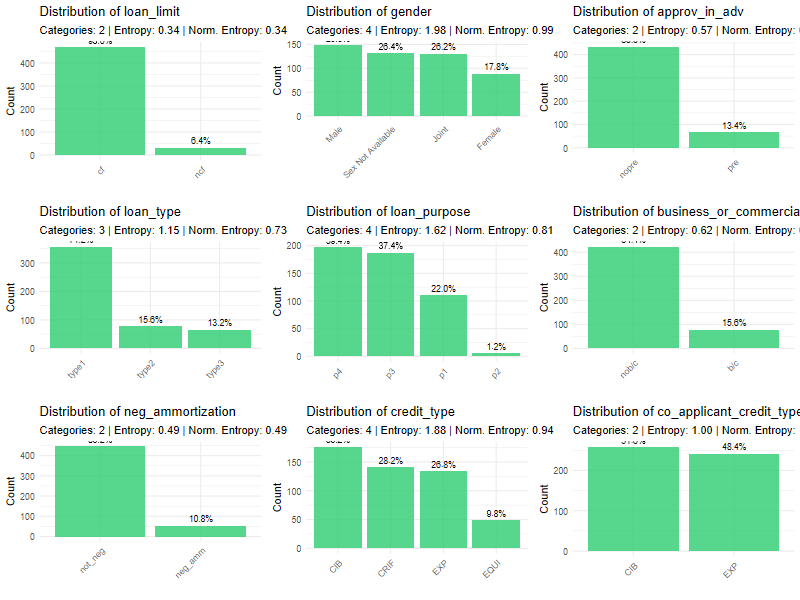

In [17]:
# Compute categorical variable statistics
compute_categorical_stats <- function(data, variable) {
  # Generate frequency table with percentages
  freq_table <- table(data[[variable]])
  freq_df <- as.data.frame(freq_table) %>%
    rename(Category = Var1, Count = Freq) %>%
    mutate(Percentage = Count / sum(Count) * 100) %>%
    arrange(desc(Count))
  
  # Compute Shannon's entropy
  entropy_value <- entropy(freq_df$Count, unit = "log2")
  norm_entropy <- entropy_value / log2(nrow(freq_df))
  
  # Return a list of statistical summaries
  list(
    freq_df = freq_df,
    entropy = entropy_value,
    normalized_entropy = norm_entropy,
    num_categories = nrow(freq_df)
  )
}

# Create bar plot for categorical variable
create_categorical_bar_plot <- function(data, variable) {
  # Compute statistics
  stats <- compute_categorical_stats(data, variable)
  freq_df <- stats$freq_df
  
  # Create bar plot
  ggplot(freq_df, aes(reorder(Category, -Count), Count)) +
    geom_bar(stat = "identity", fill = "#2ecc71", alpha = 0.8) +
    geom_text(
      aes(label = sprintf("%.1f%%", Percentage)),
      vjust = -0.5,
      color = "black", 
      size = 3
    ) +
    labs(
      title = paste("Distribution of", variable),
      subtitle = sprintf(
        "Categories: %d | Entropy: %.2f | Norm. Entropy: %.2f",
        stats$num_categories, 
        stats$entropy, 
        stats$normalized_entropy
      ),
      x = "", 
      y = "Count"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

# Visualize multiple categorical variables
visualize_categorical_variables <- function(data, max_plots = 9) {
  # Identify categorical columns
  categorical_cols <- data %>%
    select(where(~ !is.numeric(.))) %>%
    names()
  
  # Check if categorical columns exist
  if (length(categorical_cols) == 0) {
    warning("No categorical columns found in the dataset.")
    return(NULL)
  }
  
  # Limit number of plots
  num_plots <- min(max_plots, length(categorical_cols))
  
  # Dynamically adjust grid layout
  num_cols <- ceiling(sqrt(num_plots))
  num_rows <- ceiling(num_plots / num_cols)
  
  # Generate plots
  plot_list <- lapply(
    head(categorical_cols, num_plots), 
    function(col) create_categorical_bar_plot(data, col)
  )
  
  # Arrange plots
  do.call(grid.arrange, c(plot_list, ncol = num_cols, nrow = num_rows))
}

# Create a summary report of categorical variables
summarize_categorical_variables <- function(data) {
  # Identify categorical columns
  categorical_cols <- data %>%
    select(where(~ !is.numeric(.))) %>%
    names()
  
  # Compute statistics for each categorical variable
  cat_summaries <- lapply(categorical_cols, function(col) {
    stats <- compute_categorical_stats(data, col)
    
    list(
      variable = col,
      num_categories = stats$num_categories,
      entropy = stats$entropy,
      normalized_entropy = stats$normalized_entropy,
      top_categories = head(stats$freq_df, 3)
    )
  })
  
  # Return the summaries
  cat_summaries
}


categorical_plots <- visualize_categorical_variables(data)
ggsave(filename= "../plots/eda_images/Categorical Plots.png", plot = categorical_plots, dpi = 300, width = 8, height = 8)
cat_summaries <- summarize_categorical_variables(data)

In [18]:
cat_summaries

[[1]]
[[1]]$variable
[1] "loan_limit"

[[1]]$num_categories
[1] 2

[[1]]$entropy
[1] 0.3431229

[[1]]$normalized_entropy
[1] 0.3431229

[[1]]$top_categories
  Category Count Percentage
1       cf   468       93.6
2      ncf    32        6.4


[[2]]
[[2]]$variable
[1] "gender"

[[2]]$num_categories
[1] 4

[[2]]$entropy
[1] 1.976629

[[2]]$normalized_entropy
[1] 0.9883143

[[2]]$top_categories
           Category Count Percentage
1              Male   148       29.6
2 Sex Not Available   132       26.4
3             Joint   131       26.2


[[3]]
[[3]]$variable
[1] "approv_in_adv"

[[3]]$num_categories
[1] 2

[[3]]$entropy
[1] 0.568307

[[3]]$normalized_entropy
[1] 0.568307

[[3]]$top_categories
  Category Count Percentage
1    nopre   433       86.6
2      pre    67       13.4


[[4]]
[[4]]$variable
[1] "loan_type"

[[4]]$num_categories
[1] 3

[[4]]$entropy
[1] 1.152679

[[4]]$normalized_entropy
[1] 0.7272597

[[4]]$top_categories
  Category Count Percentage
1    type1   356       71.2


# 4. Bivariate Analysis

## 4.1 Relationship Between Target Variable and Numeric Predictors

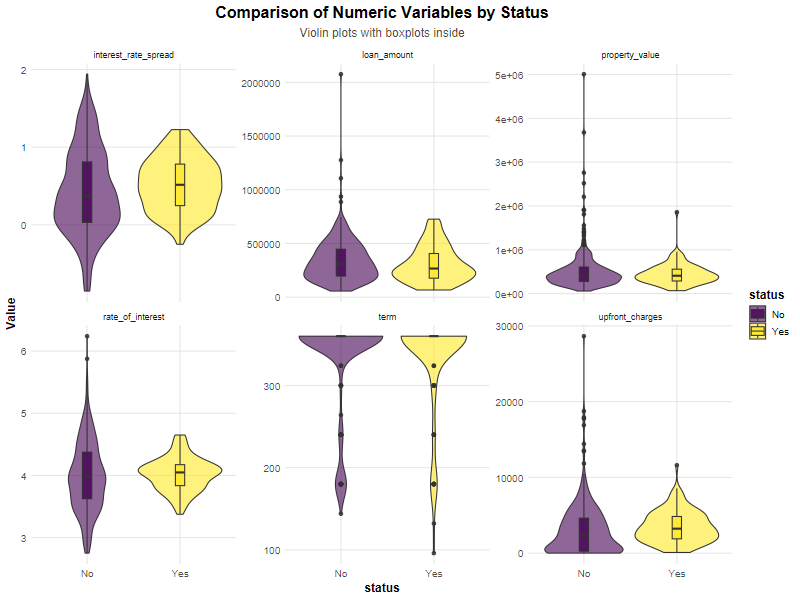

In [19]:
target_var <- "status"
violin_plot_data <- data %>%
    select(all_of(c(target_var, numeric_cols[1:min(6, length(numeric_cols))]))) %>%
    pivot_longer(cols = -all_of(target_var), names_to = "Variable", values_to = "Value")

plot_violin <- function(data = violin_plot_data) {
  violin <- ggplot(violin_plot_data, aes(x = .data[[target_var]], y = Value, fill = .data[[target_var]])) +
    geom_violin(alpha = 0.6) +
    geom_boxplot(width = 0.1, alpha = 0.8) +
    scale_fill_viridis_d() +
    facet_wrap(~ Variable, scales = "free_y", ncol = 3) +
    labs(
      title = "Comparison of Numeric Variables by Status",
      subtitle = "Violin plots with boxplots inside",
      x = target_var,
      y = "Value"
    ) +
    theme_custom()
  ggsave(filename= "../plots/eda_images/violin by status.png", plot = violin, dpi = 300, width = 8, height = 8)
  print(violin)
}

plot_violin()


## 4.2 Correlation Analysis

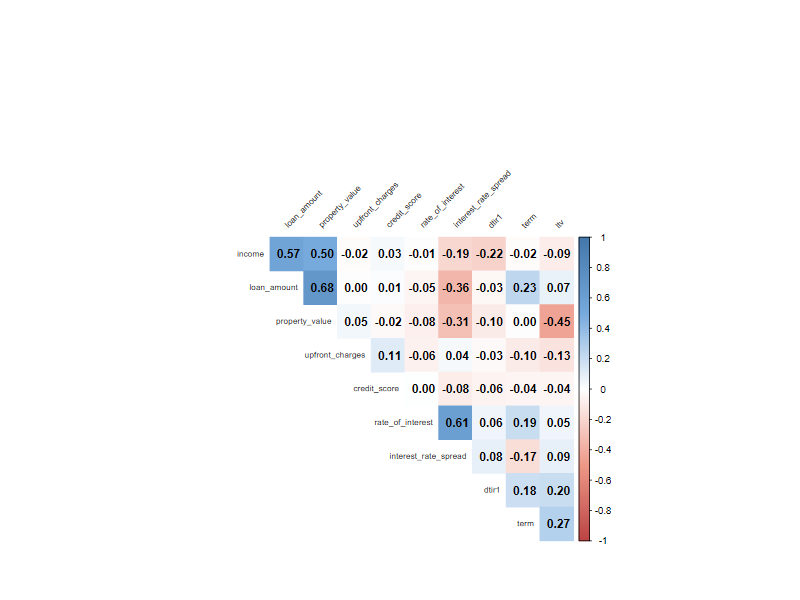

In [22]:
# Compute correlation matrix
cor_matrix <- cor(data[, numeric_cols], use = "pairwise.complete.obs")
correlation_matrix <- function(data, save_path = "../plots/eda_images/correlation_matrix.png") {
    # Ensure the directory exists
    dir.create(dirname(save_path), showWarnings = FALSE, recursive = TRUE) 
    
    # Define color palette
    col_palette <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
  
    png(filename = save_path, width = 2600, height = 2600, res = 300)
    corrplot(
        cor_matrix, method = "color", col = col_palette(200),
        type = "upper", order = "hclust",
        addCoef.col = "black", 
        tl.col = "black", tl.srt = 45, tl.cex = 0.7,  # Reduce text size
        sig.level = 0.01, insig = "blank",
        diag = FALSE
    )
    dev.off()  # Close the graphics device
    
    plot.new()
    corrplot(
        cor_matrix, method = "color", col = col_palette(200),
        type = "upper", order = "hclust",
        addCoef.col = "black", 
        tl.col = "black", tl.srt = 45, tl.cex = 0.7, 
        sig.level = 0.01, insig = "blank",
        diag = FALSE
    )
}

correlation_matrix(data)


### Network plot of correlations

### Correlation Network Communities

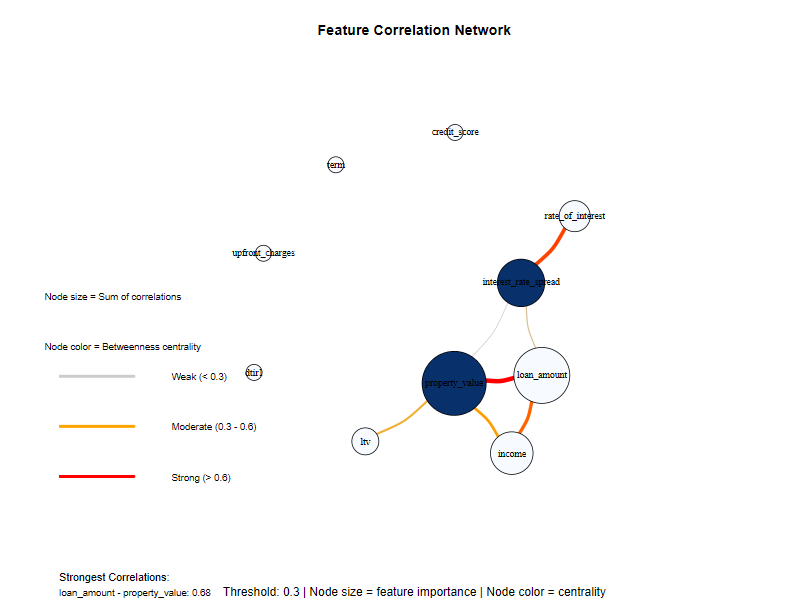

In [23]:
network_plots <- function(cor_matrix, threshold = 0.3){
  # Define correlation strength labels and corresponding colors
legend_labels <- c("Weak (< 0.3)", "Moderate (0.3 - 0.6)", "Strong (> 0.6)")
correlation_colors <- c("#CCCCCC", "#FFA500", "#FF0000")  

# Apply threshold to correlation matrix
cor_filtered <- cor_matrix
cor_filtered[abs(cor_filtered) < threshold] <- 0  # Filter weak correlations
diag(cor_filtered) <- 0  # Remove self-correlations

# Ensure no missing values
cor_filtered[is.na(cor_filtered)] <- 0

# Create network graph from adjacency matrix
net <- graph_from_adjacency_matrix(
  abs(cor_filtered),
  mode = "undirected",
  weighted = TRUE,
  diag = FALSE
)

# Calculate node metrics
btw <- betweenness(net, normalized = TRUE)
strength <- strength(net)

# Set vertex attributes
V(net)$size <- 10 + 30 * rescale(strength)  # Normalize sizes
V(net)$color <- colorRampPalette(brewer.pal(9, "Blues"))(100)[cut(rescale(btw), breaks = 100, labels = FALSE)]

# Set edge attributes
E(net)$width <- 1 + 5 * rescale(E(net)$weight)
E(net)$color <- colorRampPalette(c("#CCCCCC", "#FFA500", "#FF0000"))(100)[cut(rescale(E(net)$weight), breaks = 100, labels = FALSE)]

# Create layout
set.seed(42)
graph_layout <- layout_with_fr(net)

# Plot network
plot(net,
     layout = graph_layout,
     main = "Feature Correlation Network",
     sub = paste("Threshold:", threshold, "| Node size = feature importance | Node color = centrality"),
     vertex.label.color = "black",
     vertex.label.cex = 0.8,
     edge.curved = 0.2,
     edge.arrow.size = 0,
     margin = c(0.15, 0.15, 0.15, 0.15)
)

# Move the correlation strength legend slightly left
legend("bottomleft",
       legend = legend_labels,
       col = correlation_colors,
       lwd = 4,
       bty = "n",
       cex = 0.8,
       inset = c(-0.1, 0) # Move it slightly outside the plot
)


# Move the node properties legend slightly outside the plot
legend("topright",
       legend = c("Node size = Sum of correlations", 
                  "Node color = Betweenness centrality"),
       bty = "n",
       cex = 0.8,
       inset = c(-0, 0.4), # Move it slightly outside
       xpd = TRUE 
)


# Add top correlations
if (ecount(net) > 0) {
  top_edges <- head(E(net)[order(E(net)$weight, decreasing = TRUE)], 5)
  if (length(top_edges) > 0) {
    mtext("Strongest Correlations:", side = 1, line = 3, adj = 0, cex = 0.9)
    for (i in 1:length(top_edges)) {
      edge <- top_edges[i]
      edge_ends <- ends(net, edge)
      v1 <- V(net)[edge_ends[1]]$name
      v2 <- V(net)[edge_ends[2]]$name
      weight <- round(E(net)[edge]$weight, 2)
      mtext(paste0(v1, " - ", v2, ": ", weight), side = 1, line = 3 + i, adj = 0, cex = 0.8)
    }
  }
}
  
  return(net)
}
net <- network_plots(cor_matrix, threshold = 0.3)
#ggsave(filename= "../plots/network plot.png", plot = net, dpi = 300, width = 8, height = 8)


Community membership:
Community 1 : loan_amount property_value income ltv 
Community 2 : rate_of_interest interest_rate_spread 
Community 3 : upfront_charges 
Community 4 : term 
Community 5 : credit_score 
Community 6 : dtir1 


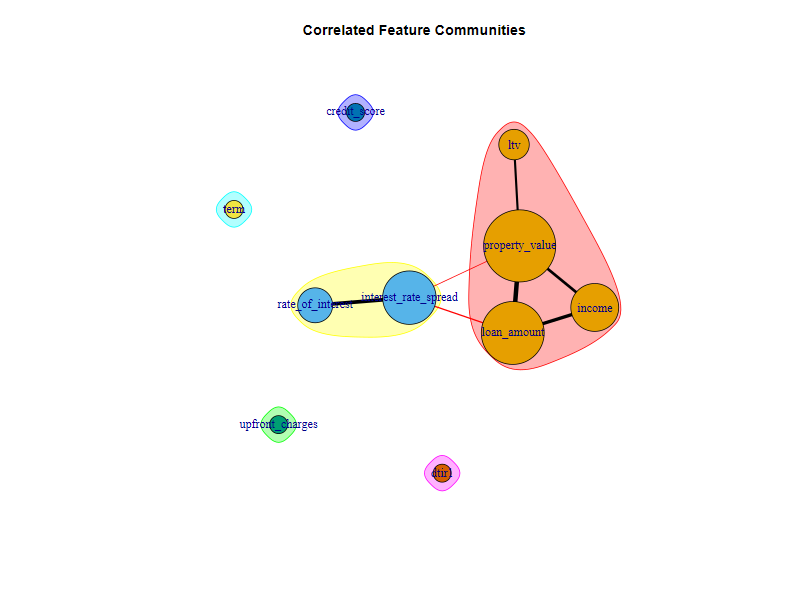

In [24]:
network_communities <- function(net, save_path = "../plots/eda_images/community_network.png") {
  
  # Community detection using Louvain algorithm
  comm <- cluster_louvain(net)
  
  # Save the plot
  png(save_path, width = 2600, height = 2600, res = 300)
  plot(comm, net, layout = layout_with_fr(net), main = "Correlated Feature Communities")
  dev.off()
 
  cat("Community membership:\n")
  for (i in 1:max(membership(comm))) {
    cat("Community", i, ":", names(membership(comm))[membership(comm) == i], "\n")
  }
  
  return(list(network = net, communities = comm))
}

community_net <- network_communities(net)
plot(community_net$communities, community_net$network, layout = layout_with_fr(community_net$network), 
     main = "Correlated Feature Communities")



# 5. Multivariate Analysis

## 5.1 Scatter Plot Matrix

### 5.1.2 Select a subset of the most interesting numeric variables

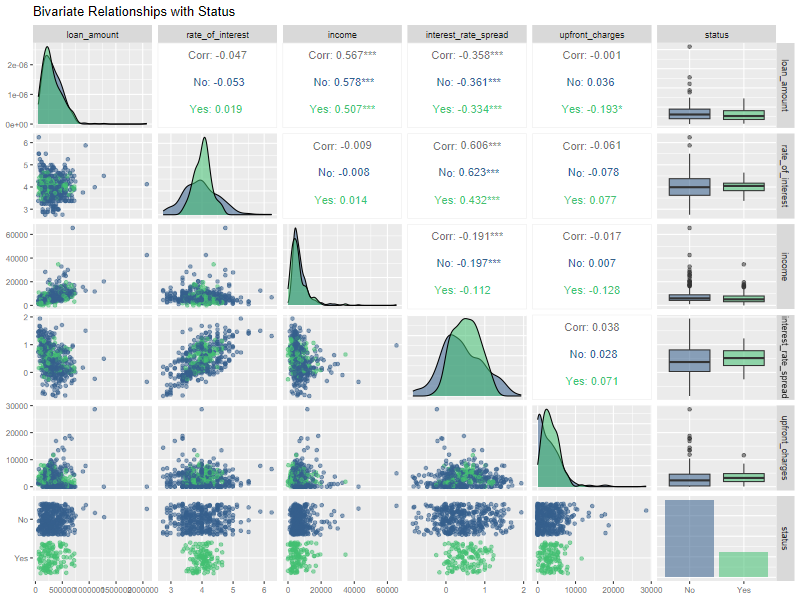

In [25]:
# Select a few key variables for bivariate analysis
bivariate_analysis <- function(data, key_vars) {
        plot <- data %>%
                select(all_of(key_vars)) %>%
                ggpairs(aes(color = status, alpha = 0.5),
                        upper = list(continuous = "cor", combo = "box_no_facet"),
                        lower = list(continuous = "points", combo = "dot_no_facet"),
                        diag = list(continuous = "densityDiag"),
                        progress = FALSE) +
                scale_color_viridis_d(option = "D", begin = 0.3, end = 0.7) +
                scale_fill_viridis_d(option = "D", begin = 0.3, end = 0.7) +
                labs(title = "Bivariate Relationships with Status") +
                theme(axis.text = element_text(size = 8),
                strip.text = element_text(size = 9))
                ggsave(filename= "../plots/eda_images/scatter_matrix.png", plot = plot, dpi = 300, width = 8, height = 8)
        return(plot)
}

key_vars <- c("loan_amount", "rate_of_interest", "income", "interest_rate_spread", "upfront_charges", "status")
bivariate_analysis(data, key_vars)
      

## 5.2 Dimensionality Reduction and Visualization
### 5.2.1 Sparse PCA

Sparse PCA aims to find principal components that explain the maximum variance while having as few non-zero loadings as possible. This helps identify the most important features (genes, clinical markers, etc.) that characterize different cancer subtypes.

In [26]:
num_data <- data %>% 
  select(any_of(numeric_cols))

# Examine the dataset structure
dim_desc <- paste("Dataset dimensions:", paste(dim(num_data), collapse = "x"))
feature_desc <- paste("First few feature names:", 
                      paste(colnames(num_data)[1:11], collapse=", "), "...")
cat(dim_desc, "\n", feature_desc)

## Center and scale the data

loan_scaled <- scale(num_data)


Dataset dimensions: 500x10 
 First few feature names: loan_amount, rate_of_interest, interest_rate_spread, upfront_charges, term, property_value, income, credit_score, ltv, dtir1, NA ...

In [27]:
hierarchical_clustering_plot <- function(data, k = 5, method = "ward.D2", label_size = 0.8) {
  # Compute distance matrix
  feature_dist <- dist(t(data))
  
  # Perform hierarchical clustering
  feature_hclust <- hclust(feature_dist, method = method)
  
  # Convert to dendrogram and color branches
  feature_dend <- as.dendrogram(feature_hclust) %>%
    color_branches(k = k)
  
  # Adjust margins to prevent text cutoff
  par(mar = c(10, 4, 4, 2))  # Increase bottom margin
  
  # Plot dendrogram with readable labels
  png("../plots/eda_images/dendogram.png", width = 800, height = 800, res = 300)
  plot(feature_dend, 
       main = "Hierarchical Clustering of Numerical Features",
       xlab = "", 
       sub = "",
       cex = label_size,  # Adjust label size
       las = 2)  # Rotate labels for better readability
  dev.off()
}

hierarchical_clustering_plot(loan_scaled, k = 5, label_size = 1)


Cannot find directory ]8;;file://c:/Users/oland/Desktop/R stuff/LoanDefault/notebooks/../plots/dimensionality_reduction../plots/dimensionality_reduction]8;;.
ℹ Would you like to create a new directory?

1: Yes
2: No

Enter an item from the menu, or 0 to exit
Enter an item from the menu, or 0 to exit
✔ Created directory: ]8;;file://c:/Users/oland/Desktop/R stuff/LoanDefault/notebooks/../plots/dimensionality_reduction../plots/dimensionality_reduction]8;;.


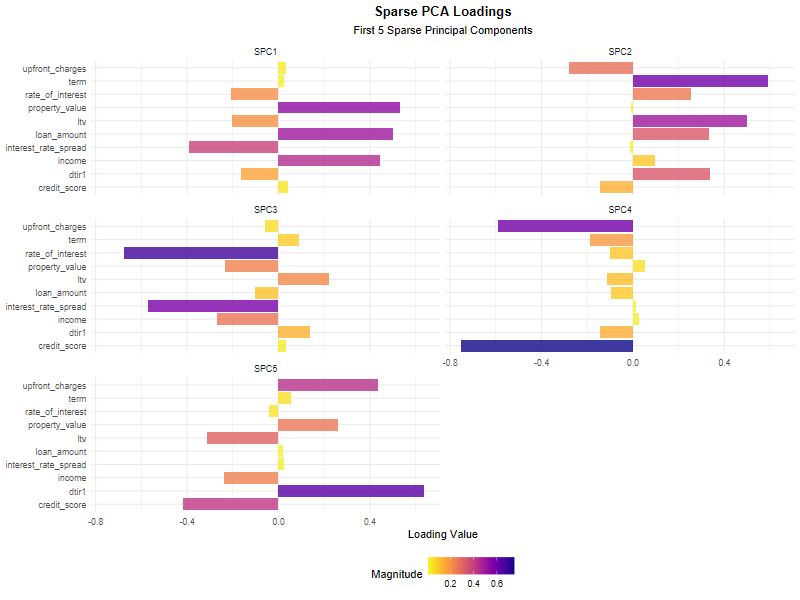

In [28]:
perform_sparse_pca <- function(data, n_components = 5, sparsity = 0.4) {
  # Compute covariance matrix
  loan_cov <- cov(data)
  
  # Perform Sparse PCA
  sparse_pca <- spca(data,
                      K = n_components, 
                      para = rep(sparsity, n_components), 
                      type = "predictor",
                      sparse = "penalty"
                    )
  
  # Extract loadings
  loadings_sparse <- sparse_pca$loadings
  loadings_sparse_df <- as.data.frame(loadings_sparse)
  colnames(loadings_sparse_df) <- paste0("SPC", 1:ncol(loadings_sparse_df))
  loadings_sparse_df$Variable <- rownames(loadings_sparse_df)
  
  # Convert to long format for visualization
  loadings_sparse_long <- pivot_longer(loadings_sparse_df,
                                      cols = starts_with("SPC"),
                                      names_to = "Component",
                                      values_to = "Loading")

  # Create visualization
  p <- ggplot(loadings_sparse_long, aes(Variable, Loading, fill = abs(Loading))) +
    geom_bar(stat = "identity", alpha = 0.8) +
    facet_wrap(~ Component, ncol = 2) +
    coord_flip() +
    scale_fill_viridis(option = "plasma", direction = -1) +
    labs(title = "Sparse PCA Loadings",
         subtitle = paste("First", n_components, "Sparse Principal Components"),
         x = NULL,
         y = "Loading Value",
         fill = "Magnitude") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5, face = "bold"),
          plot.subtitle = element_text(hjust = 0.5),
          legend.position = "bottom")
  ggsave(filename= "../plots/dimensionality_reduction/spca_loadings.png", plot = p, dpi = 300, width = 8, height = 8)
  return(list(sparse_pca = sparse_pca, plot = p, loadings_sparse = loadings_sparse))
}

sparse_result <- perform_sparse_pca(loan_scaled)
sparse_result$plot


### 5.2.2 Tuning the Sparsity Parameter

The sparsity parameter controls the trade-off between variance explained and interpretability. Let's examine how different lambda values affect sparsity:

In [29]:
perform_sparse_pca_tuning <- function(data, n_components = 5, sparsity_range = seq(0.1, 0.9, 0.1)) {
  # Compute covariance matrix
  loan_cov <- cov(data)
  spca_results <- list()
  
  # Perform Sparse PCA for different sparsity levels
  for (i in seq_along(sparsity_range)) {
    spca_results[[i]] <- spca(loan_cov, K = n_components, 
                             para = rep(sparsity_range[i], n_components),
                             type = "Gram", sparse = "penalty")
  }

  # Function to estimate variance explained for SPCA
  calc_spca_var <- function(X, loadings) {
    scores <- X %*% loadings
    explained_var <- apply(scores, 2, var)
    total_var <- sum(apply(X, 2, var))
    return(explained_var / total_var * 100)
  }

  # Compute sparsity metrics
  sparsity_metrics <- data.frame(
    sparsity = sparsity_range,
    nonzero_loadings = sapply(spca_results, function(x) mean(colSums(x$loadings != 0))),
    stringsAsFactors = FALSE
  )

  # Calculate variance explained for each sparsity level
  for (i in seq_along(sparsity_range)) {
    sparsity_metrics$var_explained_pc1_5[i] <- 
      sum(calc_spca_var(data, spca_results[[i]]$loadings)[1:n_components])
  }

  # Choose optimal sparsity level based on variance explained vs sparsity tradeoff
  best_idx <- which.max(sparsity_metrics$var_explained_pc1_5 / sparsity_metrics$nonzero_loadings)
  optimal_sparsity <- sparsity_range[best_idx]

  # Display results
  result_table <- knitr::kable(sparsity_metrics, digits = 2, 
                               caption = paste("Sparsity-Variance Tradeoff (Optimal: ", optimal_sparsity, ")"))

  return(list(spca_results = spca_results, sparsity_metrics = sparsity_metrics, 
              optimal_sparsity = optimal_sparsity, result_table = result_table))
}

result <- perform_sparse_pca_tuning(loan_scaled)
print(result$result_table)




Table: Sparsity-Variance Tradeoff (Optimal:  0.7 )

| sparsity| nonzero_loadings| var_explained_pc1_5|
|--------:|----------------:|-------------------:|
|      0.1|              3.4|               73.81|
|      0.2|              2.2|               71.44|
|      0.3|              1.8|               70.27|
|      0.4|              1.8|               70.17|
|      0.5|              1.8|               69.99|
|      0.6|              1.8|               69.53|
|      0.7|              1.6|               65.76|
|      0.8|              1.6|               65.09|
|      0.9|              1.6|               65.15|


In [30]:
# Function to calculate sparsity (% of zero loadings)
calculate_sparsity <- function(loadings_matrix) {
  total_elements <- prod(dim(loadings_matrix))
  zero_elements <- sum(loadings_matrix == 0)
  return(zero_elements / total_elements * 100)
}

# Function to perform sparse PCA tuning
perform_sparse_pca_tuning <- function(data, n_components = 4, lambda_values = seq(0.1, 0.9, by = 0.1)) {
  # Compute covariance matrix
  data_cov <- cov(data)
  
  # Initialize results dataframe
  sparsity_results <- data.frame(
    lambda = lambda_values,
    sparsity = numeric(length(lambda_values)),
    variance_explained = numeric(length(lambda_values))
  )
  
  # Iterate over different sparsity parameters
  for (i in seq_along(lambda_values)) {
    lambda <- lambda_values[i]
    
    # Run sparse PCA 
    spca_result <- spca(data_cov, 
                        K = n_components,
                        para = rep(lambda, n_components),
                        type = "Gram",
                        sparse = "penalty")
    
    # Calculate sparsity
    sparsity_results$sparsity[i] <- calculate_sparsity(spca_result$loadings)
    
    # Calculate variance explained
    scores <- data_cov %*% spca_result$loadings
    var_explained <- sum(apply(scores, 2, var)) / sum(apply(data_cov, 2, var)) * 100
    sparsity_results$variance_explained[i] <- var_explained
  }
  
  return(sparsity_results)
}

# Function to visualize the sparsity-variance tradeoff
plot_sparse_pca_tradeoff <- function(sparsity_results) {
  sparsity_results_long <- pivot_longer(sparsity_results, 
                                        cols = c("sparsity", "variance_explained"),
                                        names_to = "metric",
                                        values_to = "value")

  p <- ggplot(sparsity_results_long, aes(x = lambda, y = value, color = metric, group = metric)) +
    geom_line(size = 1.2) +
    geom_point(size = 3) +
    labs(title = "Sparsity-Variance Trade-off in Sparse PCA",
         x = "Sparsity Parameter (λ)",
         y = "Percentage",
         color = "Metric") +
    scale_color_manual(values = c("#E69F00", "#56B4E9"),
                      labels = c("Sparsity (%)", "Variance Explained (%)")) +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5, face = "bold"),
          legend.position = "bottom",
          legend.title = element_blank())
  ggsave(filename= "../plots/dimensionality_reduction/spca_tradeoff.png", plot = p, dpi = 300, width = 8, height = 8)
}

sparse_pca_results <- perform_sparse_pca_tuning(loan_scaled)
plot_sparse_pca_tradeoff(sparse_pca_results)


Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


## 5.3 Standard PCA


Sampling bootstrap replicates... Please wait

Calculating confidence intervals of empirical statistics... Please wait

Sampling random permutations... Please wait

Comparing empirical statistics with their null distributions... Please wait

Test of PCA significance: 10 variables, 500 observations
1000 bootstrap replicates, 1000 random permutations

Empirical Psi = 4.5974, Max null Psi = 0.3147, Min null Psi = 0.0740, p-value = 0
Empirical Phi = 0.2260, Max null Phi = 0.0591, Min null Phi = 0.0287, p-value = 0

Empirical eigenvalue #1 = 2.52544, Max null eigenvalue = 1.33799, p-value = 0
Empirical eigenvalue #2 = 1.60646, Max null eigenvalue = 1.24322, p-value = 0
Empirical eigenvalue #3 = 1.41481, Max null eigenvalue = 1.17603, p-value = 0
Empirical eigenvalue #4 = 1.06439, Max null eigenvalue = 1.11972, p-value = 0.362
Empirical eigenvalue #5 = 0.98049, Max null eigenvalue = 1.08091, p-value = 0.97
Empirical eigenvalue #6 = 0.84053, Max null eigenvalue = 1.02892, p-value = 1
Empirica

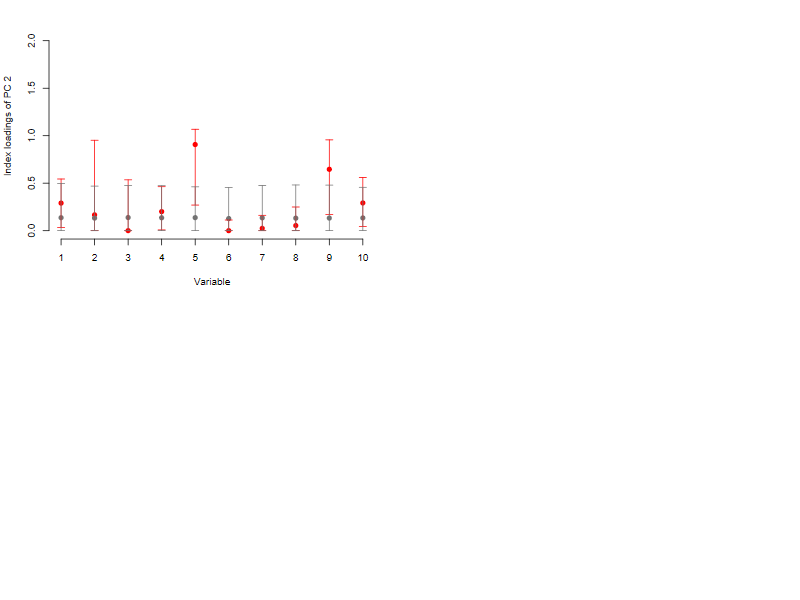

In [31]:
# Perform PCA
set.seed(42)
results <- PCAtest(num_data,
                  nperm = 1000,
                  nboot = 1000,
                  alpha = 0.05,
                  #scale = FALSE,
                  counter = FALSE,
                  plot = TRUE
                  )

In [32]:
loan_pca <- prcomp(loan_scaled, scale = FALSE, center = TRUE)

In [33]:
# Kaiser Criterion
print(get_eigenvalue(loan_pca))
# We should pick five principal components, since the eigenvalues are over 1

       eigenvalue variance.percent cumulative.variance.percent
Dim.1   2.5254354        25.254354                    25.25435
Dim.2   1.6064622        16.064622                    41.31898
Dim.3   1.4148101        14.148101                    55.46708
Dim.4   1.0643922        10.643922                    66.11100
Dim.5   0.9804859         9.804859                    75.91586
Dim.6   0.8405256         8.405256                    84.32111
Dim.7   0.7625454         7.625454                    91.94657
Dim.8   0.4160854         4.160854                    96.10742
Dim.9   0.2494166         2.494166                    98.60159
Dim.10  0.1398410         1.398410                   100.00000


In [34]:
# Create the PCA recipe
pca_prep <- recipe(status~., data =data) |> 
  step_normalize(all_numeric_predictors()) |> 
  step_pca(all_numeric_predictors(), num_comp = 5) |> 
  prep()

In [35]:
pca_prep


── Recipe ──────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 22

── Training information 
Training data contained 500 data points and no incomplete rows.

── Operations 
• Centering and scaling for: loan_amount and rate_of_interest, ... | Trained
• PCA extraction with: loan_amount and rate_of_interest, ... | Trained

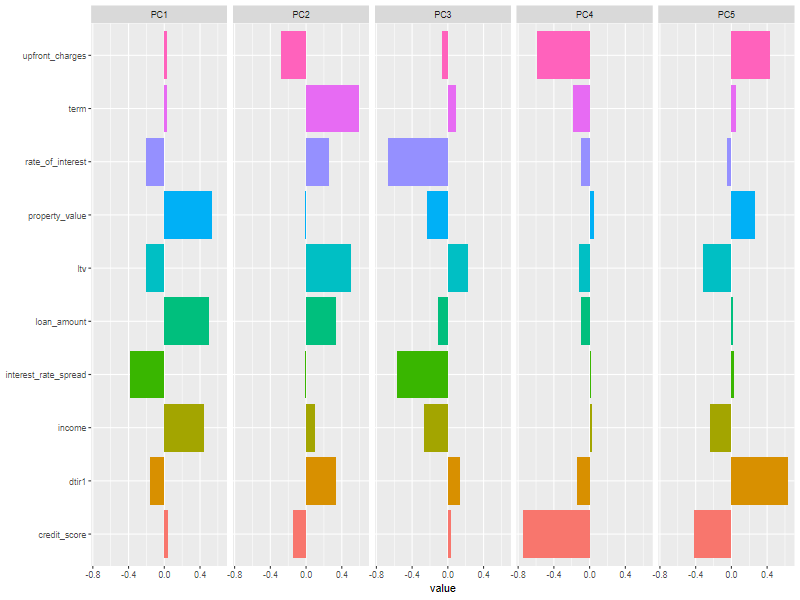

In [36]:
# Visualize the contribution of variables to the components

tidied_pca <- tidy(pca_prep, 2)
tidied_pca |> 
  filter(component %in% paste0("PC", 1:5)) |> 
  mutate(component = fct_inorder(component)) |> 
  ggplot(aes(value, terms, fill = terms)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~component, nrow = 1)+
  labs(y = NULL) -> pc_loadings

ggsave(filename= "../plots/dimensionality_reduction/PCA Loadings.png", plot = pc_loadings, dpi = 300, width = 8, height = 8)
pc_loadings

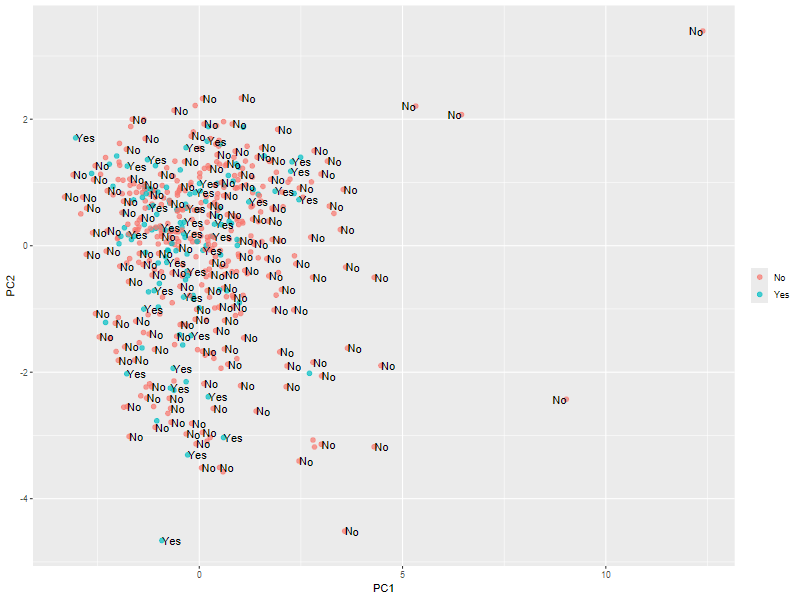

In [37]:
juice(pca_prep) %>%
  ggplot(aes(PC1, PC2, label = status)) +
  geom_point(aes(color = status), alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL) -> pc_viz

ggsave(filename= "../plots/dimensionality_reduction/pc visualization.png", plot = pc_viz, dpi = 300, width = 8, height = 8)
pc_viz

In [38]:
tidied_pca %>% 
  pivot_wider(names_from = component, values_from = value) %>% 
  select(-id) %>% 
  select(terms, PC1, PC2, PC3, PC4, PC5) -> standard_loadings

standard_loadings %>% 
  as.data.frame() -> standard_loadings

rownames(standard_loadings) <- standard_loadings$terms
standard_loadings <- standard_loadings %>% 
  select(-terms) 

sparse_loading_subset <- sparse_result$loadings_sparse[, 1:5]
colnames(sparse_loading_subset) <- paste0("SPC", 1:5)

# Combine both loadings
all_loadings <- cbind(standard_loadings, sparse_loading_subset)


## 5.4 Standard vs Sparse PCA Comparison

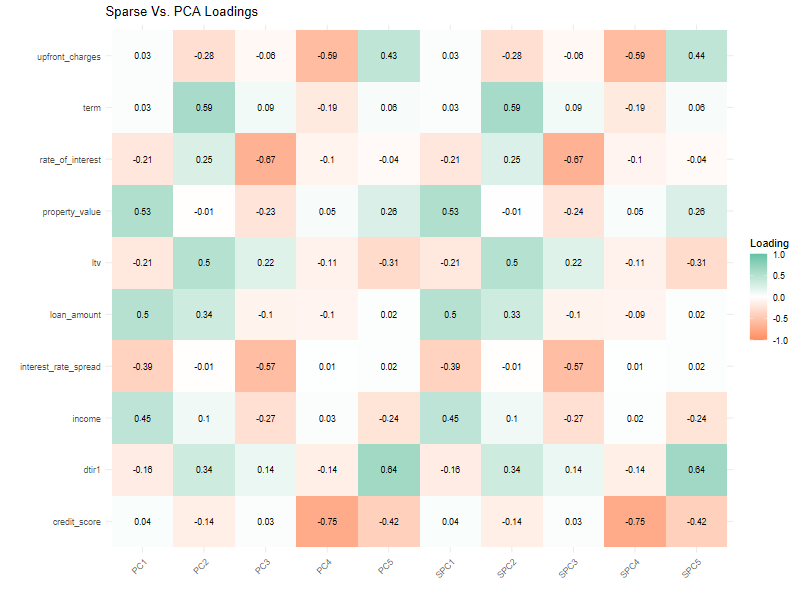

In [39]:
long_data <- all_loadings %>% 
  rownames_to_column(var = "terms") %>% 
  pivot_longer(cols = -terms, names_to = "Feature", values_to = "Loading")

ggplot(long_data, aes(Feature, terms, fill = Loading)) +
  geom_tile() +
  geom_text(aes(label = round(Loading, 2)), size = 3) +
  scale_fill_gradient2(low = "#fc8d62", mid = "white", high = "#66c2a5", 
  midpoint = 0, limits = c(-1, 1)) +
  labs(title = "Sparse Vs. PCA Loadings",
  x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) -> spcavpc

ggsave(filename= "../plots/dimensionality_reduction/SPCA vs PCA Loadings.png", plot = spcavpc, dpi = 300, width = 8, height = 8)
spcavpc

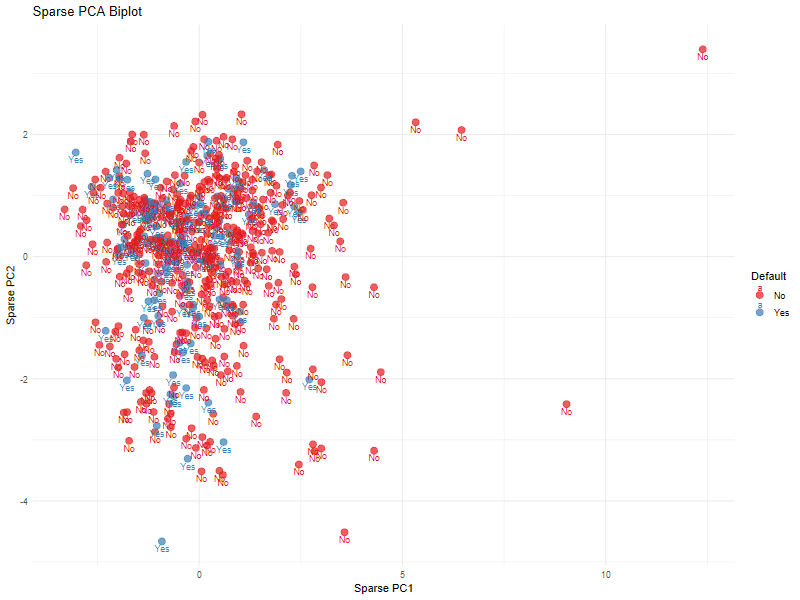

In [40]:
# Interactive Biplots for Sparse PCA
spca_scores <- loan_scaled %*% sparse_result$loadings_sparse[, 1:2]
biplot_data <- data.frame(
  PC1 = spca_scores[, 1],
  PC2 = spca_scores[, 2],
  Default = as.factor(data$status)
)

ggplot(biplot_data, aes(PC1, PC2, color = Default)) +
  geom_point(size = 3, alpha = 0.7) +
  geom_text(aes(label = Default), vjust = 1.5, size = 3) +
  scale_color_manual(values = c("#E41A1C", "#377EB8", "#4DAF4A")) +
  labs(title = "Sparse PCA Biplot",
       x = "Sparse PC1",
       y = "Sparse PC2") +
  theme_minimal() -> spca_biplot
ggsave(filename= "../plots/dimensionality_reduction/spca biplot.png", plot = spca_biplot, dpi = 300, width = 8, height = 8)
spca_biplot

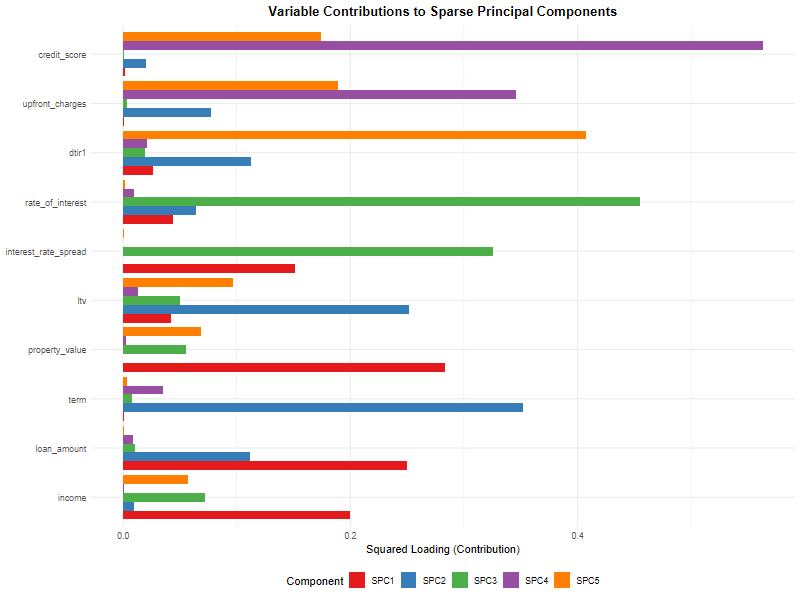

In [41]:
# Calculate variable contributions (squared loadings)
contrib_df <- as.data.frame(sparse_result$loadings_sparse^2)
colnames(contrib_df) <- paste0("SPC", 1:ncol(contrib_df))
contrib_df$Variable <- rownames(contrib_df)

contrib_long <- pivot_longer(contrib_df, 
                            cols = starts_with("SPC"), 
                            names_to = "Component", 
                            values_to = "Contribution")

# Sort by contribution within each component
contrib_long <- contrib_long %>%
  group_by(Component) %>%
  arrange(desc(Contribution)) %>%
  ungroup()

# Keep only non-zero contributions for clarity
contrib_long <- contrib_long %>% filter(Contribution > 0)

# Create a bar chart of variable contributions
ggplot(contrib_long, aes(x = reorder(Variable, Contribution), y = Contribution, fill = Component)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Variable Contributions to Sparse Principal Components",
       x = NULL,
       y = "Squared Loading (Contribution)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.position = "bottom") -> spca_varcontributions
        ggsave(filename= "../plots/dimensionality_reduction/spca variable contributions.png", plot = spca_varcontributions, dpi = 300, width = 8, height = 8)
spca_varcontributions

# 6. Feature Importance and Selection

## 6.1 Prep data

In [42]:
# Create initial train/test split (70/30)
loan_split <- initial_split(data, prop = 0.7, strata = status)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

# Create cross-validation folds for tuning
loan_folds <- vfold_cv(loan_train, v = 5, strata = status)

# Display split information
split_info <- tribble(
  ~Dataset, ~Rows, ~`status (Yes)`, ~`status (No)`, ~`status Rate (%)`,
  "Original", nrow(data), 
  sum(data$status == "Yes"), 
  sum(data$status == "No"),
  mean(data$status == "Yes") * 100,
  
  "Training", nrow(loan_train), 
  sum(loan_train$status == "Yes"), 
  sum(loan_train$status == "No"),
  mean(loan_train$status == "Yes") * 100,
  
  "Testing", nrow(loan_test), 
  sum(loan_test$status == "Yes"), 
  sum(loan_test$status == "No"),
  mean(loan_test$status == "Yes") * 100
)

kable(split_info, caption = "Data Split Overview") 



Table: Data Split Overview

|Dataset  | Rows| status (Yes)| status (No)| status Rate (%)|
|:--------|----:|------------:|-----------:|---------------:|
|Original |  500|          123|         377|        24.60000|
|Training |  349|           86|         263|        24.64183|
|Testing  |  151|           37|         114|        24.50331|

In [43]:
# Define preprocessing steps
loan_recipe <- recipe(status ~ ., data = loan_train) %>%
  
  # Handle missing values
  step_impute_knn(all_predictors(), neighbors = 5) %>%
  # Group Rare categories into other category
  step_other(all_nominal_predictors(), threshold = 0.2) %>% 
  # Treat new categories as new 
  step_novel(all_nominal_predictors()) %>% 
  
  # Create dummy variables for categorical predictors
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero variance predictors
  step_nzv(all_predictors()) %>%
  
  # Remove highly correlated predictors
  step_corr(all_numeric_predictors(), threshold = 0.7) %>%
  
  # Normalize numeric predictors
  step_normalize(all_numeric_predictors()) %>%
  
  # Handle class imbalance using SMOTE
  themis::step_smote(status, over_ratio = 0.8)

# Print the recipe
loan_recipe


── Recipe ──────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 22

── Operations 
• K-nearest neighbor imputation for: all_predictors()
• Collapsing factor levels for: all_nominal_predictors()
• Novel factor level assignment for: all_nominal_predictors()
• Dummy variables from: all_nominal_predictors()
• Sparse, unbalanced variable filter on: all_predictors()
• Correlation filter on: all_numeric_predictors()
• Centering and scaling for: all_numeric_predictors()
• SMOTE based on: status

In [44]:
# Prepare the recipe
loan_prep <- prep(loan_recipe)

# View the processed training data
loan_train_processed <- juice(loan_prep)

# Summarize the processed data
loan_train_processed %>%
  glimpse()

# Count the number of predictors after preprocessing
num_predictors <- ncol(loan_train_processed) - 1
cat("Number of predictors after preprocessing:", num_predictors)

Rows: 473
Columns: 30
$ loan_amount                       <dbl> -0.7557813, 0.8284089, 1.2739624, 1.…
$ rate_of_interest                  <dbl> 0.57680723, -1.02272803, -0.73860006…
$ interest_rate_spread              <dbl> 1.135077039, -1.095465959, 0.7766519…
$ upfront_charges                   <dbl> 0.68679751, -0.51009023, -0.96540518…
$ term                              <dbl> 0.4664898, 0.4664898, 0.4664898, 0.4…
$ property_value                    <dbl> -0.67393554, -0.05136288, 0.19321923…
$ income                            <dbl> -0.58645353, -0.18225575, 0.07373618…
$ credit_score                      <dbl> -1.39868015, -0.68026807, 1.28454571…
$ ltv                               <dbl> 0.73643094, 1.65879637, 1.45337124, …
$ dtir1                             <dbl> 0.8560351, -0.2120959, 0.3219696, -1…
$ loan_limit_other                  <dbl> -0.2590087, -0.2590087, -0.2590087, …
$ gender_Male                       <dbl> -0.6372528, -0.6372528, -0.6372528, …
$ gender_Sex.Not.A

## 6.2 Machine Learning-Based Feature Importance

### 6.2.1 Random Forest

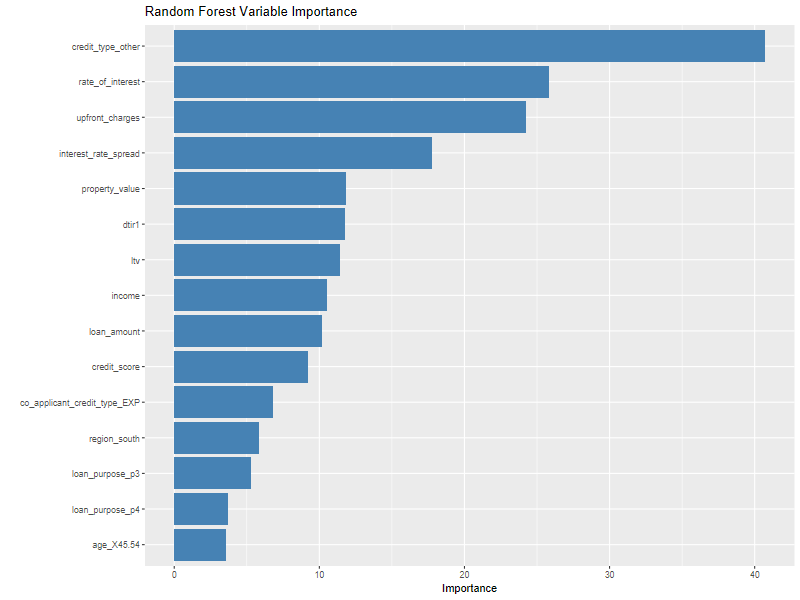

In [45]:
set.seed(42)

# Set up a random forest model
rf_model <- rand_forest() %>%
  set_engine("randomForest") %>%
  set_mode("classification") 

rf_wflow <- workflow() %>% 
  add_recipe(loan_recipe) %>% 
  add_model(rf_model)

rf_wflow %>% 
  fit(data = loan_train) -> rf_fit

fitted_rf <- extract_fit_parsnip(rf_fit)
vip(fitted_rf, num_features = 15, geom = "col", aesthetics = list(fill = "steelblue")) +
  labs(title = "Random Forest Variable Importance") -> rf_imp
ggsave(filename= "../plots/feature selection/Random ForestImportance.png", plot = rf_imp, dpi = 300, width = 8, height = 8)
rf_imp

### 6.2.2 XGBoost Feature Importance

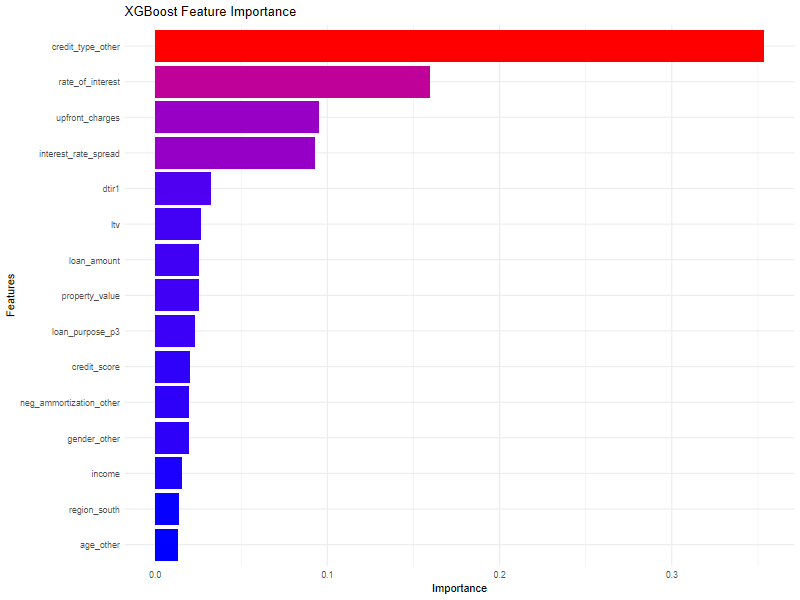

In [46]:
set.seed(42)
xgb_model <- boost_tree() %>%
  set_engine("xgboost") %>%
  set_mode("classification")

xgb_wflow <- workflow() %>%
  add_recipe(loan_recipe) %>%
  add_model(xgb_model)

xgb_fit <- xgb_wflow %>% 
  fit(data = loan_train)

fitted_xgb <- extract_fit_parsnip(xgb_fit)

feature_names <- fitted_xgb$fit$feature_names

xgb_importance <- xgb.importance(
  model = fitted_xgb$fit,
  feature_names = feature_names  
)


xgb_importance_df <- xgb_importance %>%
  slice_max(order_by = Gain, n = 15) %>% 
  mutate(Feature = factor(Feature, levels = rev(Feature))) 


ggplot(xgb_importance_df, aes(x = Feature, y = Gain, fill = Gain)) +
  geom_col(show.legend = FALSE) +
  scale_fill_gradient(low = "blue", high = "red") +
  coord_flip() +  
  labs(title = "XGBoost Feature Importance", x = "Features", y = "Importance") +
  theme_minimal() -> xgb_imp
ggsave(filename= "../plots/feature selection/XGBoost Feature Importance.png", plot = xgb_imp, dpi = 300, width = 8, height = 8)
xgb_imp

### 6.2.3 Recursive Feature Elimination
RFE is a feature selection method that recursively removes the weakest feature(s) until the specified number of features is reached.

In [48]:
library(doParallel)
# Set up parallel processing for faster computation
registerDoParallel(cores = 3)

# Define control parameters for RFE
rfe_control <- rfeControl(
  functions = nbFuncs,  #Use Naiverace
  method = "cv",        # Cross-validation
  number = 5,           # 5-fold CV
  verbose = FALSE,
  allowParallel = TRUE
)

# Run RFE
set.seed(123)
rfe_result <- rfe(
  x = loan_train_processed %>% select(-status),
  y = loan_train_processed$status,
  sizes = c(1:10, 15, 20),  
  rfeControl = rfe_control
)

stopImplicitCluster()

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel



Recursive feature selection

Outer resampling method: Cross-Validated (5 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.7506 0.4635    0.04189 0.09740         
         2   0.7506 0.4635    0.04189 0.09740         
         3   0.7548 0.4732    0.04054 0.09364         
         4   0.7611 0.4874    0.04596 0.10523         
         5   0.7527 0.4694    0.04907 0.11087         
         6   0.7611 0.4881    0.04034 0.09155         
         7   0.7738 0.5168    0.04198 0.09395         
         8   0.7759 0.5214    0.04459 0.09936         
         9   0.7823 0.5368    0.04741 0.10667         
        10   0.7971 0.5684    0.05232 0.11685         
        15   0.8203 0.6218    0.06087 0.13173         
        20   0.8330 0.6480    0.05571 0.12063         
        29   0.8330 0.6501    0.04426 0.09626        *

The top 5 variables (out of 29):
   credit_type_other, upfront_charges, co_applicant_credit_type_EXP, reg

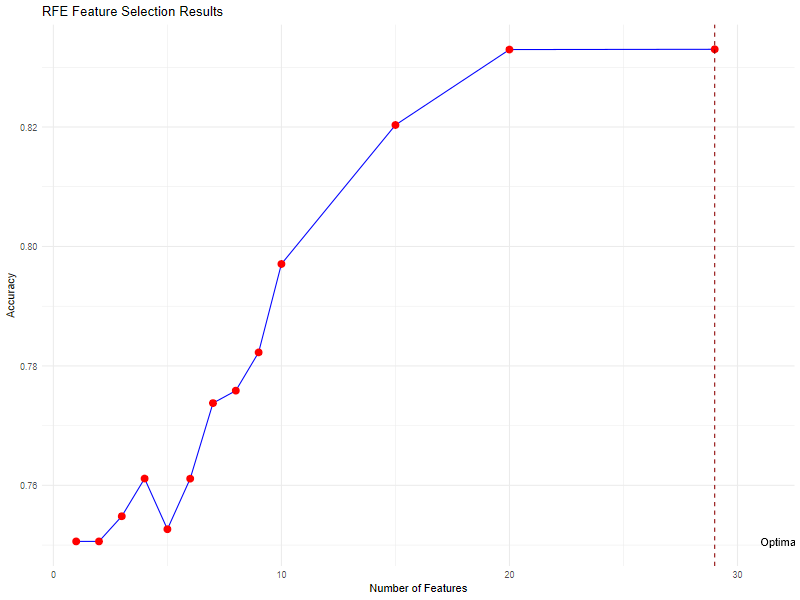

In [49]:
# Print RFE results
print(rfe_result)

# Plot the results
plot(rfe_result, type = c("g", "o"))

# Get the optimal features
optimal_vars <- predictors(rfe_result)
cat("Optimal features selected by RFE:", paste(optimal_vars, collapse = ", "))

# Plot the selected feature set performance
ggplot(data = data.frame(
  Variables = rfe_result$results$Variables,
  Accuracy = rfe_result$results$Accuracy
)) +
  geom_line(aes(x = Variables, y = Accuracy), color = "blue") +
  geom_point(aes(x = Variables, y = Accuracy), color = "red", size = 3) +
  geom_vline(xintercept = rfe_result$optsize, linetype = "dashed", color = "darkred") +
  annotate("text", x = rfe_result$optsize + 2, y = min(rfe_result$results$Accuracy), 
           label = paste("Optimal size:", rfe_result$optsize), hjust = 0) +
  labs(title = "RFE Feature Selection Results",
       x = "Number of Features",
       y = "Accuracy") +
  theme_minimal() -> rfeplot
ggsave(filename= "../plots/feature selection/RFE Feature Importance.png", plot = rfeplot, dpi = 300, width = 8, height = 8)
rfeplot

### 6.2.4 Lasso Regression

Warning message:
In select_best(.) :
  No value of `metric` was given; "roc_auc" will be used.


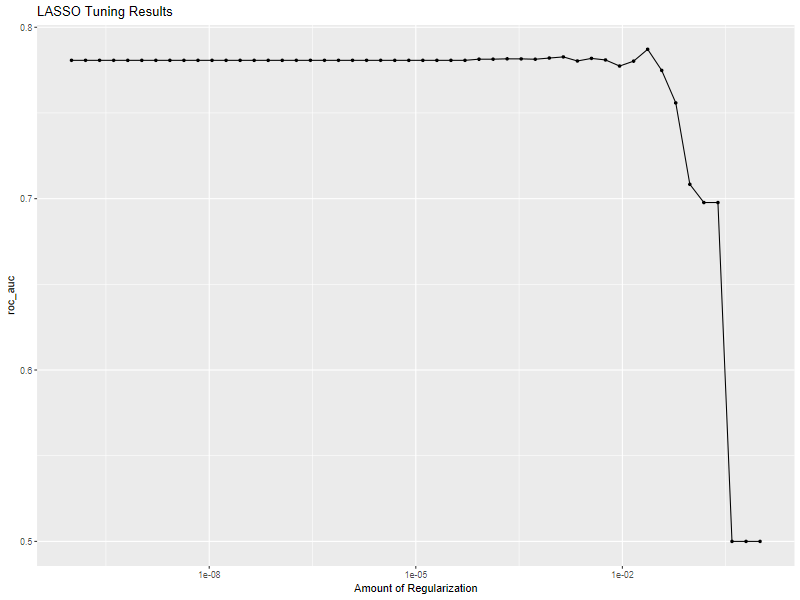

In [50]:
doParallel::stopImplicitCluster()

set.seed(123)
lasso_spec <- logistic_reg(penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

# Set up the workflow
lasso_wf <- workflow() %>%
  add_recipe(loan_recipe) %>% 
  add_model(lasso_spec)

# Set up grid of lambda values
lambda_grid <- grid_regular(penalty(), levels = 50)

# Set up resampling
folds <- vfold_cv(loan_train, v = 5, strata = status)

# Tune LASSO model
lasso_tune <- tune_grid(
  lasso_wf,
  resamples = folds,
  grid = lambda_grid,
  metrics = metric_set(roc_auc),
  control = control_grid(allow_par = FALSE)
)


# Get best lambda
best_lambda <- lasso_tune %>%
  select_best()

# Finalize workflow and fit model
lasso_final <- lasso_wf %>%
  finalize_workflow(best_lambda) %>%
  fit(data = loan_train)

# Extract lasso coefficients
lasso_coefs <- lasso_final %>%
  extract_fit_parsnip() %>%
  tidy() %>%
  filter(estimate != 0, term != "(Intercept)") %>%
  arrange(desc(abs(estimate)))

# Visualize LASSO coefficients
lasso_coefs %>%
  mutate(term = str_replace_all(term, "loan_purpose_", "Purpose: ")) %>%
  slice_head(n = 20) %>%
  ggplot(aes(x = reorder(term, abs(estimate)), y = estimate, fill = estimate > 0)) +
  geom_col() +
  scale_fill_manual(values = c("red", "blue"), labels = c("Negative", "Positive")) +
  coord_flip() +
  labs(title = "Top 20 LASSO Coefficients",
       x = "Features",
       y = "Coefficient Estimate",
       fill = "Direction") +
  theme_minimal()

# Plot the tuning results
autoplot(lasso_tune) +
  labs(title = "LASSO Tuning Results") -> lasso_results
ggsave(filename= "../plots/feature selection/Lasso Tuning.png", plot = lasso_results, dpi = 300, width = 8, height = 8)
lasso_results


In [51]:
x <- as.matrix(loan_train_processed %>% select(-status))
y <- loan_train_processed$status

# Perform Lasso with a range of lambda values
lasso_model <- glmnet(x = x, 
                      y = y, 
                      alpha = 1, 
                      family = "binomial")

# Extract coefficients for plotting
coef_df <- lasso_model %>%
  tidy() %>%
  filter(term != "(Intercept)") %>%
  mutate(abs_estimate = abs(estimate))

# Create a more informative plot
coef_plot <- ggplot(coef_df, aes(x = log(lambda), y = estimate, color = term)) +
  geom_line() +
  labs(title = "Lasso Coefficient Path",
       x = "Log(Lambda)",
       y = "Coefficient Value",
       color = "Features") +
  theme_light() +
  theme(legend.position = "right",
        legend.text = element_text(size = 8)) +
  guides(color = guide_legend(override.aes = list(size = 0.5)))

# Save the plot
ggsave(filename= "../plots/feature selection/Lasso Coefficient Path.png",
 plot = coef_plot,
  dpi = 300,
   width = 8,
    height = 8)

# Perform cross-validation to find optimal lambda
lasso_cv <- cv.glmnet(x = x, 
                      y = y,
                      alpha = 1,
                      family = "binomial")

# Extract coefficients at optimal lambda
optimal_coef <- coef(lasso_cv, s = "lambda.min")
print("Coefficients at optimal lambda:")
print(optimal_coef)

# Optional: Create a bar plot of absolute coefficient values at optimal lambda
optimal_coef_df <- as.matrix(optimal_coef) %>%
  as.data.frame() %>%
  rownames_to_column("term") %>%
  rename(coefficient = s1) %>%
  filter(term != "(Intercept)") %>%
  mutate(abs_coefficient = abs(coefficient)) %>%
  arrange(desc(abs_coefficient))

optimal_coef_plot <- ggplot(optimal_coef_df, aes(x = reorder(term, abs_coefficient), y = abs_coefficient)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Absolute Coefficient Values at Optimal Lambda",
       x = "Features",
       y = "Absolute Coefficient Value") +
  theme_light()

ggsave(filename= "../plots/feature selection/Optimal Coefficient Path.png",
 plot = optimal_coef_plot,
  dpi = 300,
   width = 8,
    height = 8)

[1] "Coefficients at optimal lambda:"
30 x 1 sparse Matrix of class "dgCMatrix"
                                           s1
(Intercept)                       -0.61256567
loan_amount                        .         
rate_of_interest                   .         
interest_rate_spread               .         
upfront_charges                    0.20061826
term                               0.31525734
property_value                     .         
income                            -0.29802721
credit_score                       0.14359374
ltv                                0.39863045
dtir1                              0.26542440
loan_limit_other                  -0.07644349
gender_Male                        0.21833753
gender_Sex.Not.Available          -0.18981166
gender_other                       0.30340137
approv_in_adv_other               -0.08525094
loan_type_other                   -0.09770748
loan_purpose_p3                    0.68257065
loan_purpose_p4                    0.14444920


### 6.2.5 Elastic Net


❯  Generating a set of 5 initial parameter results
✓ Initialization complete

i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussian process model
✓ Gaussian process model
i Generating 5000 candidates
i Predicted candidates
i Estimating performance
✓ Estimating performance
i Gaussia

Warning message:
In select_best(.) :
  No value of `metric` was given; "roc_auc" will be used.


                                term     estimate
1                  credit_type_other  0.125209385
2       co_applicant_credit_type_EXP  0.048841036
3                    credit_type_EXP -0.043638133
4                       region_south  0.040139288
5                    loan_purpose_p3  0.037743952
6                   credit_type_CRIF -0.037614508
7                    upfront_charges  0.032922256
8                              dtir1  0.032003744
9                             income -0.030194260
10                        age_X45.54 -0.029926612
11                   loan_purpose_p4 -0.026862117
12           neg_ammortization_other  0.026368688
13                    property_value -0.020356598
14                              term  0.019926583
15                         age_other  0.019637438
16                               ltv  0.016097670
17                       loan_amount -0.015299831
18 submission_of_application_to_inst  0.012399894
19              interest_rate_spread  0.011789503


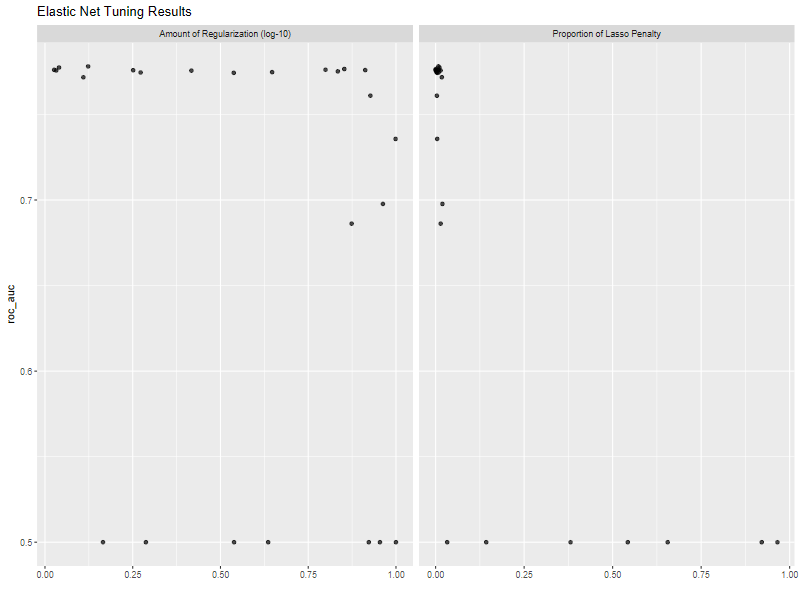

In [52]:
cl <- makeCluster(parallel::detectCores() - 1)
registerDoParallel(cl)

set.seed(42)
enet_spec <- logistic_reg(penalty = tune(), mixture = tune()) %>%
  set_engine("glmnet")

enet_wf <- workflow() %>%
  add_model(enet_spec) %>%
  add_recipe(loan_recipe)

enet_tune <- enet_wf %>%
  tune_bayes(
    resamples = folds,
    param_info = parameters(penalty(range = c(1e-4, 1)), mixture(range = c(0, 1))),  
    metrics = metric_set(roc_auc),
    iter = 20,  
    initial = 5,  
    control = control_bayes(no_improve = 5, verbose = TRUE)  
  )

autoplot(enet_tune) +
  labs(title = "Elastic Net Tuning Results") -> enet_tuneplot
ggsave(filename= "../plots/feature selection/ElasticNet Tuning.png",
 plot = enet_tuneplot,
  dpi = 300,
   width = 8,
    height = 8)
print(enet_tuneplot)

best_enet <- enet_tune %>%
  select_best()

# Finalize workflow and fit model
enet_final <- enet_wf %>%
  finalize_workflow(best_enet) %>%
  fit(data = loan_train)

# Extract Elastic Net coefficients using direct access to model object
model_fit <- extract_fit_parsnip(enet_final)
glmnet_model <- model_fit$fit

# Get coefficients for the specific lambda value
coef_matrix <- coef(glmnet_model, s = best_enet$penalty)
# Convert sparse matrix to data frame
coef_df <- data.frame(
  term = rownames(coef_matrix),
  estimate = as.numeric(coef_matrix)
) %>%
  filter(estimate != 0, term != "(Intercept)") %>%
  arrange(desc(abs(estimate)))

# Display the top coefficients
print(coef_df)

stopCluster(cl)

In [53]:
coef_df %>%
  slice_head(n = 20) %>%
  ggplot(aes(x = reorder(term, abs(estimate)), y = estimate, fill = estimate > 0)) +
  geom_col() +
  scale_fill_manual(values = c("red", "blue"), labels = c("Negative", "Positive")) +
  coord_flip() +
  labs(title = "Top 20 Elastic Net Coefficients",
       x = "Features",
       y = "Coefficient Estimate",
       fill = "Direction") +
  theme_minimal() -> enet_coef_plots

ggsave(filename= "../plots/feature selection/ElasticNet Coefficients.png",
 plot = enet_coef_plots,
  dpi = 300,
   width = 8,
    height = 8)

## 6.3 Compare the different feature selection techniques



Table: Top 10 Features from Each Method

|RandomForest         |XGBoost              |RFE                          |LASSO                   |ElasticNet                   |
|:--------------------|:--------------------|:----------------------------|:-----------------------|:----------------------------|
|credit_type_other    |credit_type_other    |credit_type_other            |credit_type_other       |credit_type_other            |
|rate_of_interest     |rate_of_interest     |upfront_charges              |loan_purpose_p3         |co_applicant_credit_type_EXP |
|upfront_charges      |upfront_charges      |co_applicant_credit_type_EXP |age_X45.54              |credit_type_EXP              |
|interest_rate_spread |interest_rate_spread |region_south                 |term                    |region_south                 |
|property_value       |dtir1                |income                       |income                  |loan_purpose_p3              |
|dtir1                |ltv              

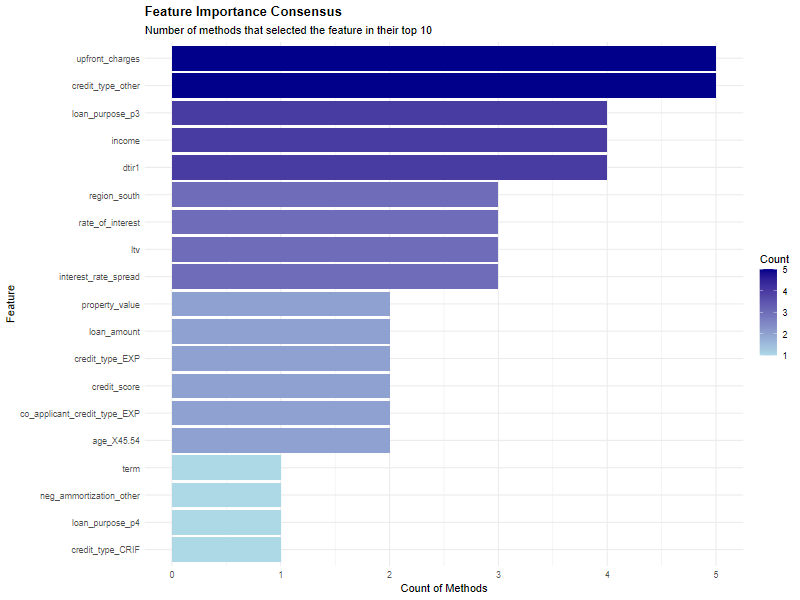

In [54]:
top_xgb <- xgb_importance %>% 
  slice_head(n = 10) %>% 
  pull(Feature)

top_rfe <- optimal_vars[1:min(10, length(optimal_vars))]
top_lasso <- lasso_coefs %>%
  slice_head(n = 10) %>%
  pull(term)

top_enet <- coef_df %>%
  slice_head(n = 10) %>%
  pull(term)

top_rf <- vip::vi(fitted_rf) %>% 
  arrange(desc(Importance)) %>%
  slice_head(n = 10) %>% 
  pull(Variable)

comparison_df <- data.frame(
  RandomForest = c(top_rf, rep(NA, 10 - length(top_rf))),
  XGBoost = c(top_xgb, rep(NA, 10 - length(top_xgb))),
  RFE = c(top_rfe, rep(NA, 10 - length(top_rfe))),
  LASSO = c(top_lasso, rep(NA, 10 - length(top_lasso))),
  ElasticNet = c(top_enet, rep(NA, 10 - length(top_enet)))
)
kable(comparison_df, caption = "Top 10 Features from Each Method") %>% 
  print()


count_feature_importance <- function(feature, methods_list) {
  sum(sapply(methods_list, function(method) feature %in% method))
}

all_features <- unique(c(top_rf, top_xgb, 
  top_rfe, top_lasso, top_enet))
all_features <- all_features[!is.na(all_features)]


feature_counts <- sapply(all_features, function(feat) {
count_feature_importance(feat, list(top_rf, top_xgb, 
              top_rfe, top_lasso, top_enet))
})


feature_counts_df <- data.frame(
Feature = names(feature_counts),
Count = as.numeric(feature_counts)
)

feature_counts_df %>%
arrange(desc(Count)) %>%
slice_head(n = 20) %>%
ggplot(aes(x = reorder(Feature, Count), y = Count, fill = Count)) +
geom_bar(stat = "identity") +
scale_fill_gradient(low = "lightblue", high = "darkblue") +
coord_flip() +
labs(title = "Feature Importance Consensus",
subtitle = "Number of methods that selected the feature in their top 10",
x = "Feature",
y = "Count of Methods") +
theme_minimal() +
theme(plot.title = element_text(face ="bold")) -> feature_counts_compare
ggsave(filename= "../plots/feature selection/Feature Counts comparison.png",
 plot = feature_counts_compare,
  dpi = 300,
   width = 8,
    height = 8)
feature_counts_compare


Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases
Setting levels: control = No, case = Yes
Setting direction: controls < cases


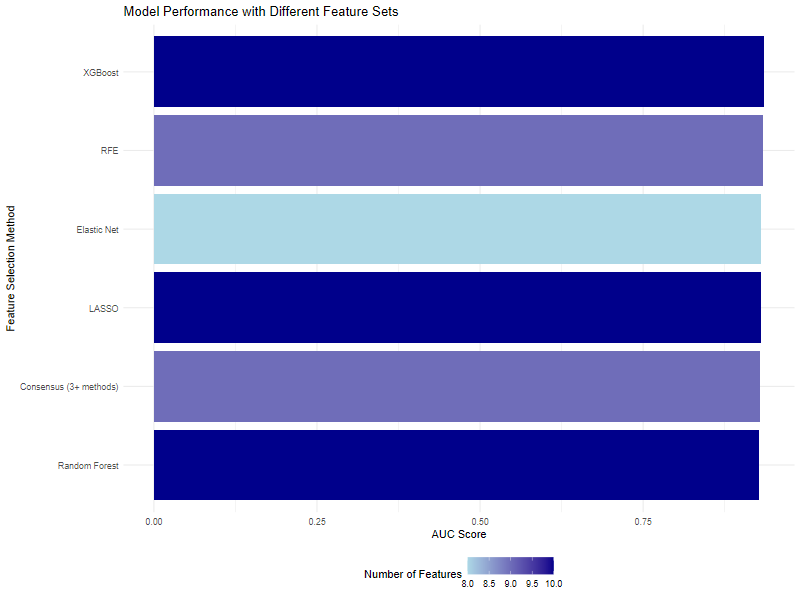

In [55]:
# How do these models perform based on the  selected features?
# Define a function to train and evaluate a model
evaluate_feature_set <- function(features, name) {
  
  # Prep the recipe
  feature_prep <- prep(loan_recipe)
  train_processed <- bake(feature_prep, new_data = loan_train)
  test_processed <- bake(feature_prep, new_data = loan_test)
  
  # Train a random forest model
  rf_model <- rand_forest() %>%
    set_engine("randomForest") %>%
    set_mode("classification") %>%
    fit(status ~ ., data = train_processed)
  
  # Make predictions
  preds <- predict(rf_model, test_processed, type = "prob") %>%
    bind_cols(test_processed) %>%
    select(status, .pred_Yes)
  
  # Calculate performance metrics
  roc_obj <- roc(preds$status, preds$.pred_Yes)
  auc_value <- auc(roc_obj)
  
  # Return results
  return(list(
    name = name,
    auc = auc_value,
    roc = roc_obj,
    features = features
  ))
}

get_base_features <- function(terms) {
  base_features <- unique(sapply(terms, function(term) {
    
    # Special case handling
    term <- gsub("submission_of_application_to_inst", "submission_of_application", term)
    
    # Remove common suffixes
    term <- gsub("_(other|EXP|CRIF|to_inst|to)$", "", term)
    
    # Remove trailing underscores with categories (like loan_purpose_auto -> loan_purpose)
    term <- gsub("_(auto|p4|mortgage|south|Male|X[0-9.]+)$", "", term)
    
    return(term)
  }))
  
  return(base_features)
}


features <- c("credit_type_other", "rate_of_interest", "upfront_charges", "interest_rate_spread",
              "dtir1", "ltv", "income", "property_value", "credit_score", 
              "co_applicant_credit_type_EXP", "neg_ammortization_other", 
              "submission_of_application_to_inst", "business_or_commercial_other", 
              "approv_in_adv_other", "credit_type_CRIF", "credit_type_EXP", 
              "occupancy_type_other", "loan_limit_other", "loan_purpose_auto",
              "loan_purpose_p4", "region_south", 
              "gender_Male", "age_X55.64")

# Get the base features for the top models

rf_features <- get_base_features(top_rf)
xgb_features <- get_base_features(top_xgb)
rfe_features <- get_base_features(top_rfe)
lasso_features <- get_base_features(top_lasso)
enet_features <- get_base_features(top_enet)

# Get consensus features (features that appear in multiple methods)
all_base_features <- unique(c(rf_features, xgb_features, rfe_features, 
  get_base_features(top_lasso), get_base_features(top_enet)))
all_base_features <- all_base_features[!is.na(all_base_features)]


feature_counts <- sapply(all_base_features, function(feat) {
  sum(
  feat %in% rf_features,
  feat %in% xgb_features,
  feat %in% rfe_features,
  feat %in% get_base_features(top_lasso),
  feat %in% get_base_features(top_enet))
  })
  
consensus_features <- names(feature_counts[feature_counts >= 3])

# Evaluate each feature set
set.seed(42)
results_list <- list(
evaluate_feature_set(rf_features, "Random Forest"),
evaluate_feature_set(xgb_features, "XGBoost"),
evaluate_feature_set(rfe_features, "RFE"),
evaluate_feature_set(get_base_features(top_lasso), "LASSO"),
evaluate_feature_set(get_base_features(top_enet), "Elastic Net"),
evaluate_feature_set(consensus_features, "Consensus (3+ methods)")
)

# Plot ROC curves
colors <- c("blue", "green", "purple", "orange", "brown", "black")
plot(results_list[[1]]$roc, col = colors[1], main = "ROC Curves for Different Feature Sets")
for(i in 2:length(results_list)) {
lines(results_list[[i]]$roc, col = colors[i])
}
legend("bottomright", 
legend = sapply(results_list, function(r) paste0(r$name, " (AUC = ", round(r$auc, 3), ")")),
col = colors,
lwd = 2)
  
# Compare AUC values
auc_df <- data.frame(
  Method = sapply(results_list, function(r) r$name),
  AUC = sapply(results_list, function(r) r$auc),
  Features = sapply(results_list, function(r) length(r$features))
)

# Plot AUC comparison
auc_df %>%
  ggplot(aes(x = reorder(Method, AUC), y = AUC, fill = Features)) +
  geom_bar(stat = "identity") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  coord_flip() +
  labs(title = "Model Performance with Different Feature Sets",
       x = "Feature Selection Method",
       y = "AUC Score",
       fill = "Number of Features") +
  theme_minimal() +
  theme(legend.position = "bottom") -> auc_comparison

ggsave(filename= "../plots/feature selection/AUC Comparison.png",
 plot = auc_comparison,
  dpi = 300,
   width = 8,
    height = 8)

auc_comparison



## 6.4 Final Feature Selection

In [56]:
# Get the best performing feature set
best_method <- auc_df %>%
  arrange(desc(AUC)) %>%
  slice_head(n = 1)

best_method_name <- best_method$Method
best_method_idx <- which(sapply(results_list, function(r) r$name) == best_method_name)
best_features <- results_list[[best_method_idx]]$features

# Print the recommendation
cat("## Feature Selection Recommendation\n\n")
cat("Based on our analysis, the *", best_method_name, "* approach provides the best performance with an AUC of ", 
    round(best_method$AUC, 3), " using ", best_method$Features, " features.\n\n", sep = "")
cat("The recommended features for the loan default prediction model are:\n\n")
cat(paste("- ", best_features, collapse = "\n"))

final_recipe <- recipe(status ~ ., data = loan_train %>% 
  select(status, all_of(best_features))) %>% # Just join the previous recipe from here
  
  # Handle missing values
  step_impute_knn(all_predictors(), neighbors = 5) %>%
  # Group Rare categories into other category
  step_other(all_nominal_predictors(), threshold = 0.2) %>% 
  # Treat new categories as new 
  step_novel(all_nominal_predictors()) %>% 
  
  # Create dummy variables for categorical predictors
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero variance predictors
  step_nzv(all_predictors()) %>%
  
  # Remove highly correlated predictors
  step_corr(all_numeric_predictors(), threshold = 0.7) %>%
  
  # Normalize numeric predictors
  step_normalize(all_numeric_predictors()) %>%
  
  # Handle class imbalance using SMOTE
  themis::step_smote(status, over_ratio = 0.8)

loan_pca_recipe <- recipe(status ~ ., data = loan_train %>% 
    select(status, all_of(best_features))) %>% 
    step_impute_knn(all_predictors(), neighbors = 5) %>%
    step_other(all_nominal_predictors(), threshold = 0.2) %>% 
    step_novel(all_nominal_predictors()) %>% 
    step_dummy(all_nominal_predictors()) %>%
    step_nzv(all_predictors()) %>%
    step_corr(all_numeric_predictors(), threshold = 0.7) %>%
    step_normalize(all_numeric_predictors()) %>%
    step_pca(all_numeric_predictors(), num_comp = 5) %>% 
    themis::step_smote(status, over_ratio = 0.8)

## Feature Selection Recommendation

Based on our analysis, the *XGBoost* approach provides the best performance with an AUC of 0.935 using 10 features.

The recommended features for the loan default prediction model are:

-  credit_type
-  rate_of_interest
-  upfront_charges
-  interest_rate_spread
-  dtir1
-  ltv
-  loan_amount
-  property_value
-  loan_purpose_p3
-  credit_score

: [1m[33mError[39m in `select()`:[22m
[1m[22m[36mℹ[39m In argument: `all_of(best_features)`.
[1mCaused by error in `all_of()`:[22m
[33m![39m Can't subset elements that don't exist.
[31m✖[39m Element `loan_purpose_p3` doesn't exist.

In [58]:
loan_train_processed <- loan_recipe %>% 
  prep() %>% 
  bake(loan_train)

loan_pca_train_processed <- loan_pca_recipe %>%
  prep() %>% 
  bake(loan_train)

# Save the processed dataset
write.csv(loan_pca_train_processed, "data/loan_pca_train_processed.csv", row.names = FALSE)
write.csv(loan_train_processed, "data/loan_train_processed.csv", row.names = FALSE)


: [1m[33mError[39m:[22m
[33m![39m object 'loan_pca_recipe' not found

In [44]:
final_recipe


── Recipe ──────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by role
outcome:    1
predictor: 10

── Operations 
• K-nearest neighbor imputation for: all_predictors()
• Collapsing factor levels for: all_nominal_predictors()
• Novel factor level assignment for: all_nominal_predictors()
• Dummy variables from: all_nominal_predictors()
• Sparse, unbalanced variable filter on: all_predictors()
• Correlation filter on: all_numeric_predictors()
• Centering and scaling for: all_numeric_predictors()
• SMOTE based on: status

# 7. Data Modelling

## 7.1 Model Specification

In [45]:
# Define the models 
rf_spec <- rand_forest(
  mtry = tune(),
  trees = 500,
  min_n = tune()
) %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")


xgb_spec <- boost_tree(
  trees = 500,
  tree_depth = tune(),
  min_n = tune(),
  loss_reduction = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

log_reg_spec <- logistic_reg(
  penalty = tune(),
  mixture = tune()
) %>%
  set_engine("glmnet") %>%
  set_mode("classification")

nnet_spec <-
  mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>%
  set_engine('nnet') %>%
  set_mode('classification')



## 7.2 Hyperparameter Tuning(Tune Race Anova)

In [46]:
# Perform Hyperparameter tuning(Tune Race Anova) and fit the models
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)
loan_workflow <- workflow_set(
  preproc = list(loan_recipe, loan_pca_recipe),
  models = list(
    randomforest = rf_spec,
    xgboost = xgb_spec,
    logistic_regression = log_reg_spec,
    nnet = nnet_spec
  )
)

metrics <- metric_set( yardstick::f_meas,yardstick::accuracy, roc_auc, yardstick::sensitivity, yardstick::specificity, brier_class)
race_ctrl <- control_race(
  save_pred = TRUE,
  parallel_over = "everything",
  save_workflow = TRUE
)

race_results <- loan_workflow %>%
  workflow_map(
    seed = 42,
    fn = "tune_race_anova",
    resamples = loan_folds,
    grid = 10,
    metrics = metrics,
    control = race_ctrl
  )
stopCluster(cl)

i Creating pre-processing data to finalize unknown parameter: mtry
i Creating pre-processing data to finalize unknown parameter: mtry
i Creating pre-processing data to finalize unknown parameter: mtry
i Creating pre-processing data to finalize unknown parameter: mtry


In [47]:
race_results <- race_results %>% 
  mutate(wflow_id = gsub("recipe_1", "normal", wflow_id),
         wflow_id = gsub("recipe_2", "pca", wflow_id))


In [48]:
race_results

# A workflow set/tibble: 8 × 4
  wflow_id                   info             option    result   
  <chr>                      <list>           <list>    <list>   
1 normal_randomforest        <tibble [1 × 4]> <opts[4]> <race[+]>
2 normal_xgboost             <tibble [1 × 4]> <opts[4]> <race[+]>
3 normal_logistic_regression <tibble [1 × 4]> <opts[4]> <race[+]>
4 normal_nnet                <tibble [1 × 4]> <opts[4]> <race[+]>
5 pca_randomforest           <tibble [1 × 4]> <opts[4]> <race[+]>
6 pca_xgboost                <tibble [1 × 4]> <opts[4]> <race[+]>
7 pca_logistic_regression    <tibble [1 × 4]> <opts[4]> <race[+]>
8 pca_nnet                   <tibble [1 × 4]> <opts[4]> <race[+]>

In [49]:
# Rank the results based on the F1-score
race_results %>% 
  rank_results() %>% 
  filter(.metric == "f_meas") %>% 
  select(model, .config, f1_score = mean, rank)

# A tibble: 32 × 4
   model        .config               f1_score  rank
   <chr>        <chr>                    <dbl> <int>
 1 rand_forest  Preprocessor1_Model10    0.924     1
 2 rand_forest  Preprocessor1_Model01    0.921     2
 3 rand_forest  Preprocessor1_Model03    0.920     3
 4 rand_forest  Preprocessor1_Model07    0.920     4
 5 rand_forest  Preprocessor1_Model05    0.919     5
 6 rand_forest  Preprocessor1_Model08    0.916     6
 7 boost_tree   Preprocessor1_Model06    0.913     7
 8 logistic_reg Preprocessor1_Model06    0.912     8
 9 boost_tree   Preprocessor1_Model02    0.909     9
10 boost_tree   Preprocessor1_Model08    0.900    10
# ℹ 22 more rows
# ℹ Use `print(n = ...)` to see more rows

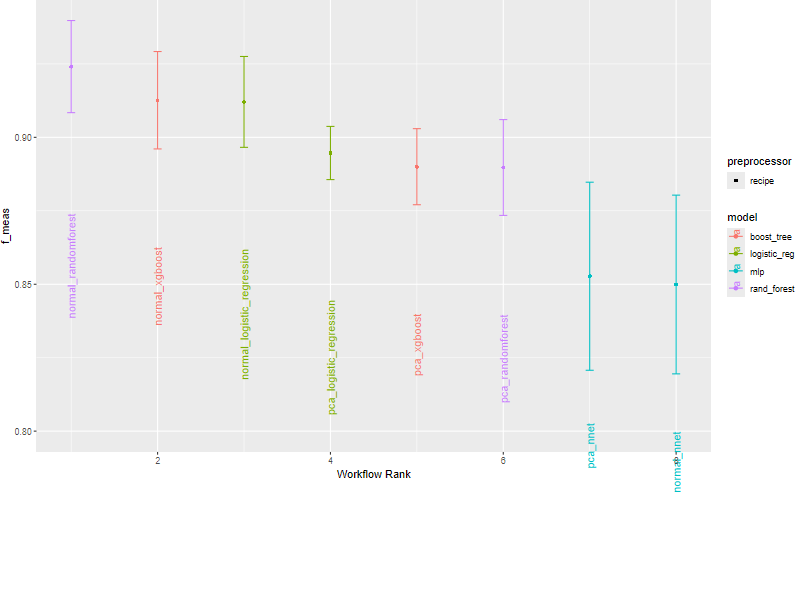

In [50]:
autoplot(race_results,
  rank_metric = "f_meas",
  metric = "f_meas",
  select_best = TRUE) +
  geom_text(aes(y = mean - 0.05, label = wflow_id), angle = 90, hjust = 1) +
  coord_cartesian(clip = "off") +
  theme(plot.margin = margin(b = 120)) -> racing_plot

ggsave(filename= "../plots/model plots/Race Plots.png",
 plot = racing_plot,
  dpi = 300,
   width = 8,
    height = 8)

racing_plot

## 7.3 Post Hoc Model Analysis
### 7.3.1 Metric Comparison

In [51]:
# Extract all metrics and predictions
all_metrics <- collect_metrics(race_results)
all_predictions <- collect_predictions(race_results)
# 1. Overall Performance Comparison
overall_comparison <- race_results %>%
  collect_metrics() %>%
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    .groups = "drop"
  ) %>%
  arrange(wflow_id, mean_perf)

overall_comparison

# A tibble: 48 × 4
   wflow_id                   .metric     mean_perf  sd_perf
   <chr>                      <chr>           <dbl>    <dbl>
 1 normal_logistic_regression brier_class     0.168 NA      
 2 normal_logistic_regression specificity     0.405 NA      
 3 normal_logistic_regression roc_auc         0.734 NA      
 4 normal_logistic_regression accuracy        0.854 NA      
 5 normal_logistic_regression f_meas          0.912 NA      
 6 normal_logistic_regression sensitivity     1     NA      
 7 normal_nnet                brier_class     0.189  0.00497
 8 normal_nnet                specificity     0.583  0.0171 
 9 normal_nnet                roc_auc         0.736  0.0178 
10 normal_nnet                accuracy        0.751  0.0192 
# ℹ 38 more rows
# ℹ Use `print(n = ...)` to see more rows

### 7.3.2 Roc Cuves Comparison

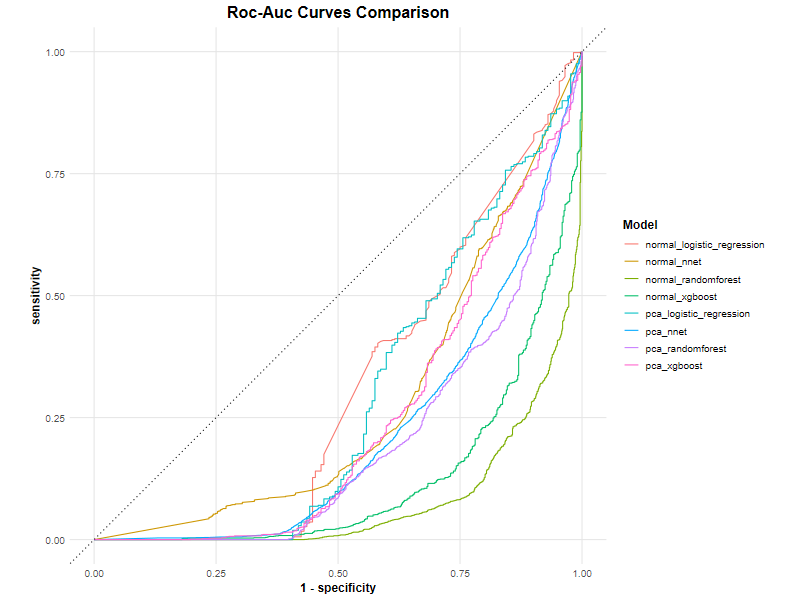

In [52]:
roc_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  roc_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_custom() +
  labs(
      title = "Roc-Auc Curves Comparison",
      color = "Model"
    )
    ggsave(filename= "../plots/model plots/Roc Curves.png",
    plot = roc_curves,
     dpi = 300,
      width = 8,
       height = 8)
roc_curves

### 7.3.3 Precision-Recall Curves

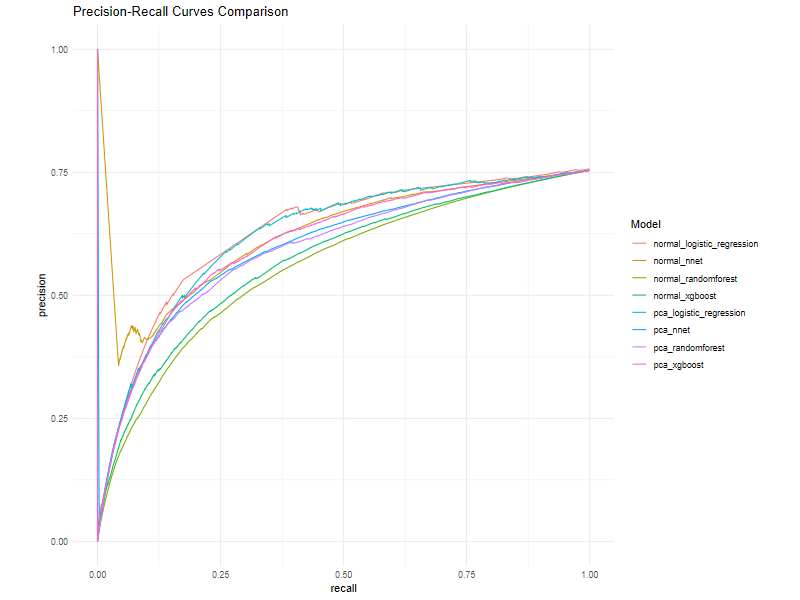

In [53]:

pr_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  pr_curve(truth = status, .pred_Yes) %>%
  autoplot() +
  theme_minimal() +
  labs(
    title = "Precision-Recall Curves Comparison",
    color = "Model"
  )
  ggsave(filename= "../plots/model plots/Precision-Recall Curves.png",
  plot = pr_curves,
   dpi = 300,
    width = 8,
     height = 8)
pr_curves

### 7.3.4. Performance Distribution Boxplots

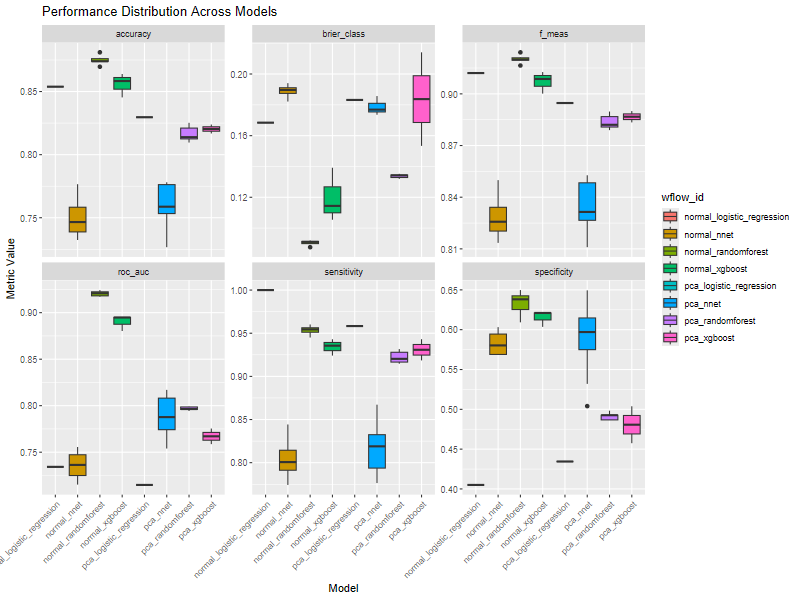

In [54]:

metric_distributions <- all_metrics %>%
  ggplot(aes(x = wflow_id, y = mean, fill = wflow_id)) +
  geom_boxplot() +
  facet_wrap(~.metric, scales = "free_y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Performance Distribution Across Models",
    x = "Model",
    y = "Metric Value"
  )

  ggsave(filename= "../plots/model plots/Metric Distributions.png",
  plot = metric_distributions,
   dpi = 300,
    width = 8,
     height = 8)

metric_distributions

### 7.3.5. Model Calibration

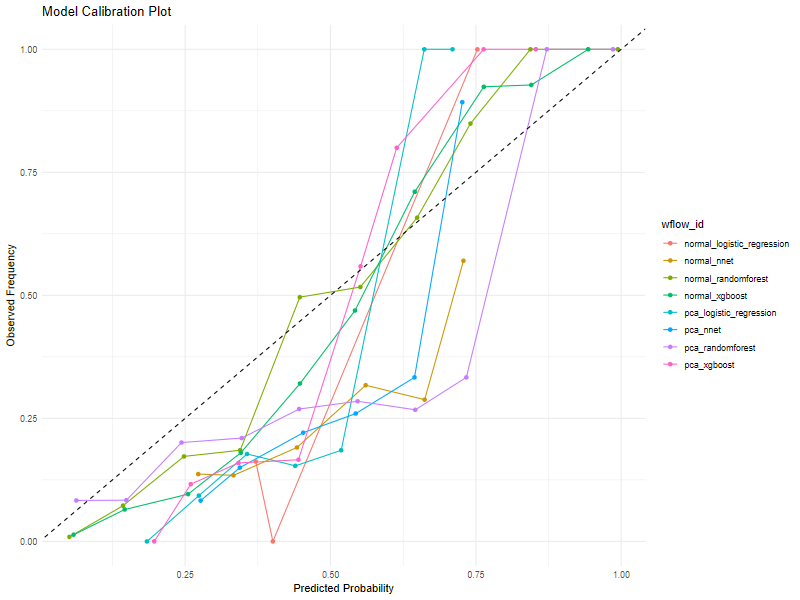

In [55]:

calibration_plots <- all_predictions %>%
  group_by(wflow_id) %>%
  mutate(pred_bin = cut(.pred_Yes, breaks = seq(0, 1, by = 0.1))) %>%
  group_by(wflow_id, pred_bin) %>%
  summarise(
    observed_prob = mean(status == "Yes"),
    predicted_prob = mean(.pred_Yes),
    .groups = "drop"
  ) %>%
  ggplot(aes(x = predicted_prob, y = observed_prob, color = wflow_id)) +
  geom_line() +
  geom_point() +
  geom_abline(linetype = "dashed") +  # Ideal calibration line
  theme_minimal() +
  labs(title = "Model Calibration Plot", x = "Predicted Probability", y = "Observed Frequency")
ggsave(filename= "../plots/model plots/Model Calibration.png",
 plot = calibration_plots,
  dpi = 300,
   width = 8,
    height = 8)
calibration_plots

### 7.3.6. Model Rankings

In [56]:

model_rankings <- all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  kable(caption = "Average model rankings based on selected metrics")

print(model_rankings)




Table: Average model rankings based on selected metrics

|wflow_id                   | mean_accuracy| mean_brier_class| mean_f_meas| mean_roc_auc| mean_sensitivity| mean_specificity| rank_accuracy| rank_brier_class| rank_f_meas| rank_roc_auc| rank_sensitivity| rank_specificity|
|:--------------------------|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|
|normal_randomforest        |     0.8749018|        0.0904233|   0.9201633|    0.9205697|        0.9535070|        0.6333894|            15|               48|           8|            7|                3|               33|
|normal_xgboost             |     0.8558770|        0.1196520|   0.9071288|    0.8900703|        0.9342378|        0.6151821|            16|               47|          10|           12|                4|               34|
|pca_randomforest           |     0.8164457|        0

### 7.3.7 Stability Plot Analysis

Warning message:
Removed 8 rows containing missing values or values outside the scale range
(`geom_col()`). 


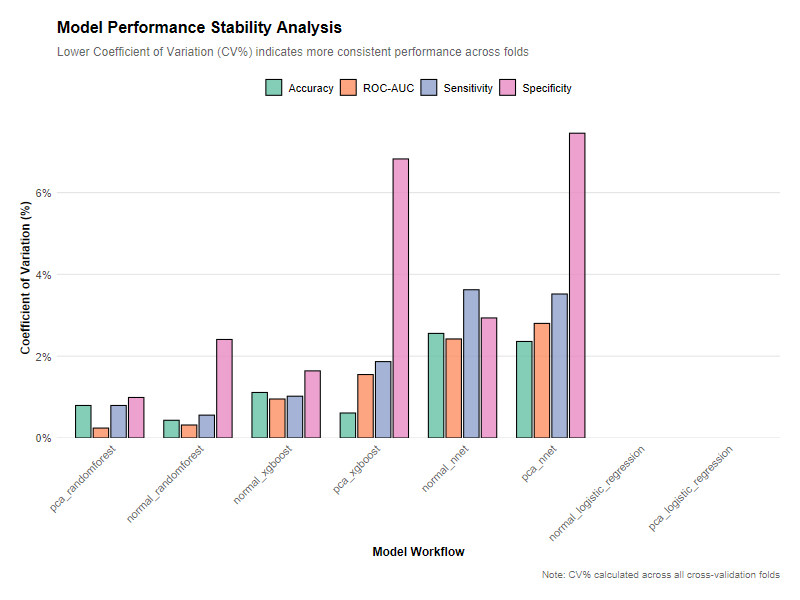

In [57]:

stability_plot <- all_metrics %>%
  # Filter for relevant metrics
  filter(.metric %in% c("accuracy", "roc_auc", "sensitivity", "specificity")) %>%
  # Calculate stability metrics
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    cv = sd_perf / mean_perf * 100,
    .groups = "drop"
  ) %>%
  # Create plot
  ggplot(aes(x = reorder(wflow_id, cv), y = cv, fill = .metric)) +
  geom_col(position = position_dodge(width = 0.8),
           width = 0.7,
           color = "black",
           alpha = 0.8) +
  # Custom color palette
  scale_fill_brewer(palette = "Set2",
                    labels = c("Accuracy", "ROC-AUC", "Sensitivity", "Specificity")) +
  # Formatting
  scale_y_continuous(
    #limits = c(0, max(cv) * 1.1),
    labels = function(x) paste0(round(x, 1), "%"),
    expand = expansion(mult = c(0, 0.05))
  ) +
  # Clean theme
  theme_minimal(base_size = 12, base_family = "Arial") +
  theme(
    plot.title = element_text(size = 16, face = "bold", margin = margin(b = 10)),
    plot.subtitle = element_text(size = 12, color = "grey40", margin = margin(b = 20)),
    plot.caption = element_text(size = 10, color = "grey40", margin = margin(t = 10)),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    legend.position = "top",
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.margin = margin(b = 10),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_line(color = "grey90"),
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Labels
  labs(
    title = "Model Performance Stability Analysis",
    subtitle = "Lower Coefficient of Variation (CV%) indicates more consistent performance across folds",
    x = "Model Workflow",
    y = "Coefficient of Variation (%)",
    caption = "Note: CV% calculated across all cross-validation folds"
  )
  ggsave(filename= "../plots/model plots/Stability Plot.png",
  plot = stability_plot,
   dpi = 300,
    width = 8,
     height = 8)
# Display the plot
stability_plot

### 7.3.8 Performance Table

In [58]:
performance_table <- overall_comparison %>%
  arrange(desc(mean_perf)) %>% # Sort by performance
  kable(digits = 3, caption = "Model Performance Summary") 
performance_table



Table: Model Performance Summary

|wflow_id                   |.metric     | mean_perf| sd_perf|
|:--------------------------|:-----------|---------:|-------:|
|normal_logistic_regression |sensitivity |     1.000|      NA|
|pca_logistic_regression    |sensitivity |     0.958|      NA|
|normal_randomforest        |sensitivity |     0.954|   0.005|
|normal_xgboost             |sensitivity |     0.934|   0.010|
|pca_xgboost                |sensitivity |     0.931|   0.017|
|pca_randomforest           |sensitivity |     0.922|   0.007|
|normal_randomforest        |roc_auc     |     0.921|   0.003|
|normal_randomforest        |f_meas      |     0.920|   0.002|
|normal_logistic_regression |f_meas      |     0.912|      NA|
|normal_xgboost             |f_meas      |     0.907|   0.006|
|pca_logistic_regression    |f_meas      |     0.895|      NA|
|normal_xgboost             |roc_auc     |     0.890|   0.008|
|pca_xgboost                |f_meas      |     0.887|   0.005|
|pca_randomforest  

### 7.3.9 Model Rankings

In [59]:
all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  mutate(wflow_id = as.character(wflow_id))-> model_rankings

model_rankings %>% kable()



|wflow_id                   | mean_accuracy| mean_brier_class| mean_f_meas| mean_roc_auc| mean_sensitivity| mean_specificity| rank_accuracy| rank_brier_class| rank_f_meas| rank_roc_auc| rank_sensitivity| rank_specificity|
|:--------------------------|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|-------------:|----------------:|-----------:|------------:|----------------:|----------------:|
|normal_randomforest        |     0.8749018|        0.0904233|   0.9201633|    0.9205697|        0.9535070|        0.6333894|            15|               48|           8|            7|                3|               33|
|normal_xgboost             |     0.8558770|        0.1196520|   0.9071288|    0.8900703|        0.9342378|        0.6151821|            16|               47|          10|           12|                4|               34|
|pca_randomforest           |     0.8164457|        0.1337212|   0.8836450|    0.7968363|        0.9222390|   

## 7.4 Test set Fit and evaluation

In [60]:
best_wflow <- model_rankings %>%
  slice(1) %>% 
  pull(wflow_id) 

best_results <- race_results %>% 
  extract_workflow_set_result(best_wflow) %>% 
  select_best(metric = "f_meas")

print(best_results)

# A tibble: 1 × 3
   mtry min_n .config              
  <int> <int> <chr>                
1    21     7 Preprocessor1_Model10


In [61]:
race_results %>% 
  extract_workflow(best_wflow) %>% 
  finalize_workflow(best_results) %>% 
  last_fit(loan_split) -> final_fit

In [62]:
collect_metrics(final_fit)

# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.927  Preprocessor1_Model1
2 roc_auc     binary        0.967  Preprocessor1_Model1
3 brier_class binary        0.0652 Preprocessor1_Model1

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[[1]]
# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.927  Preprocessor1_Model1
2 roc_auc     binary        0.967  Preprocessor1_Model1
3 brier_class binary        0.0652 Preprocessor1_Model1

[[2]]



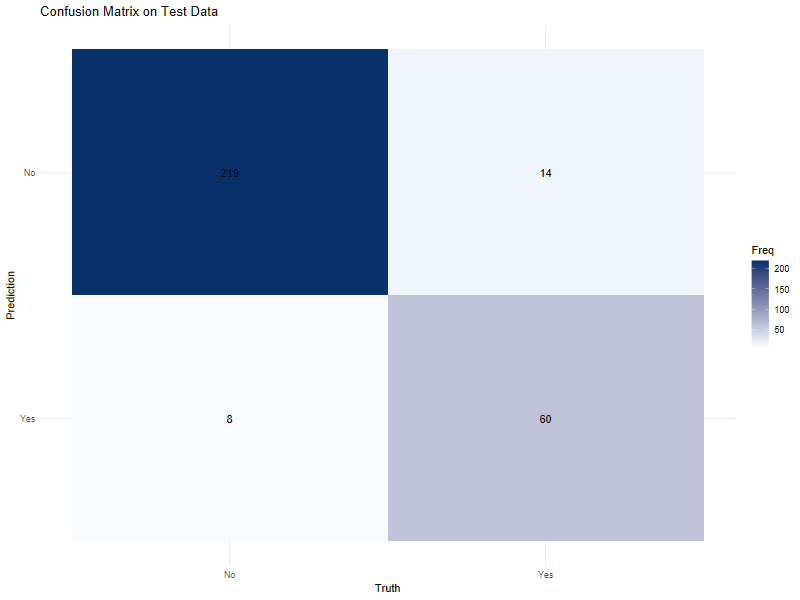

In [63]:
final_fit %>% 
  collect_predictions() %>% 
  conf_mat(truth = status, 
      estimate = .pred_class) -> conf_mat

confusion_matrix <- conf_mat %>%
  autoplot(type = "heatmap") +
  labs(title = "Confusion Matrix on Test Data") +
  scale_fill_gradient(low = "#f7fbff", high = "#08306b") +
  theme_minimal()

final_metrics <- collect_metrics(final_fit)
print(list(final_metrics, confusion_matrix))
ggsave(filename= "../plots/model plots/Confusion Matrix.png",
 plot = confusion_matrix,
  dpi = 300,
   width = 8,
    height = 8)
confusion_matrix

In [141]:
dir.create("../models", showWarnings = FALSE)
saveRDS(final_fit, "../models/final_model.rds")

In [168]:
sessioninfo::session_info()

ERROR: Unknown command "TMPDIR=C:/Users/oland/AppData/Local/Temp/RtmpMPstPn/file47b41e76ee5". Did you mean command "pandoc"?


Warning message:
In system2("quarto", "-V", stdout = TRUE, env = paste0("TMPDIR=",  :
  running command '"quarto" TMPDIR=C:/Users/oland/AppData/Local/Temp/RtmpMPstPn/file47b41e76ee5 -V' had status 1


─ Session info ───────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.4.2 (2024-10-31 ucrt)
 os       Windows 11 x64 (build 26100)
 system   x86_64, mingw32
 ui       Rgui
 language (EN)
 collate  English_Kenya.utf8
 ctype    English_Kenya.utf8
 tz       Africa/Nairobi
 date     2025-03-05
 pandoc   3.4 @ c:\\Program Files\\Positron\\resources\\app\\quarto\\bin\\tools/ (via rmarkdown)
 quarto   NA @ c:\\PROGRA~1\\Positron\\RESOUR~1\\app\\quarto\\bin\\quarto.exe

─ Packages ───────────────────────────────────────────────────────────────────
 package      * version    date (UTC) lib source
 abind          1.4-8      2024-09-12 [1] CRAN (R 4.4.1)
 askpass        1.2.1      2024-10-04 [1] CRAN (R 4.4.2)
 backports      1.5.0      2024-05-23 [1] CRAN (R 4.4.0)
 base64enc      0.1-3      2015-07-28 [1] CRAN (R 4.4.0)
 bit            4.5.0.1    2024-12-03 [1] CRAN (R 4.4.2)
 bit64          4.5.2      2024-09-22 [1] CRAN (R 4.4.2)
 bitops         

**The End**